In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data Generation

In [2]:
# Generate data
def generate_data(K, N, a, b, sigma2, seed=None):
    if seed is not None:
        np.random.seed(seed)
    theta_true = np.ones(K)
    X = np.random.uniform(a, b, N)
    # Vandermonde matrix
    Phi_X = np.vander(X, N=K, increasing=True)
    e = np.random.normal(0, np.sqrt(sigma2), N)
    Y = Phi_X @ theta_true + e
    return Phi_X ,X, Y, theta_true

In [29]:
#split data into training and test sets
def split_data(X, Y, train_ratio=0.8):
    N = len(Y)
    N_train = int(N * train_ratio)
    indices = np.random.permutation(N)
    X_train = X[indices[:N_train]]
    Y_train = Y[indices[:N_train]]
    X_test = X[indices[N_train:]]
    Y_test = Y[indices[N_train:]]
    return X_train, Y_train, X_test, Y_test

In [61]:
#produce data
def produce_data(K, N, a, b, sigma2, seed=None):    
    Phi_X, X, Y, theta_true = generate_data(K, N, a, b, sigma2, seed=0)
    X_train, Y_train, X_test, Y_test = split_data(X, Y, train_ratio=0.8)
    return X_train, Y_train, X_test, Y_test, theta_true

K = 3
N = 50
a = 0
b = 1
sigma2 = 0.1

X_train, Y_train, X_test, Y_test, theta_true = produce_data(K, N, a, b, sigma2, seed=0)

In [47]:
Phi_X_train = np.vander(X_train, N=K, increasing=True)
Phi_X_test = np.vander(X_test, N=K, increasing=True)

### Normal Equation Functions

#### 1 - Normal Equation for MLE

In [25]:
# Normal equation for MLE
def compute_mle_normal_eq(X, Y, K):
    Phi_X = np.vander(X, N=K, increasing=True)
    theta_mle = np.linalg.inv(Phi_X.T @ Phi_X) @ Phi_X.T @ Y
    return theta_mle

In [33]:
theta_mle = compute_mle_normal_eq(X_train, Y_train, K)
theta_mle

array([1.0587113 , 0.77168379, 1.21145634])

#### 2 - Normal Equation for MAP

In [35]:
# Normal equation for MAP
def compute_map_normal_eq(X, Y, K, lambda_):
    Phi_X = np.vander(X, N=K, increasing=True)
    I = np.eye(K)
    theta_map = np.linalg.pinv(Phi_X.T @ Phi_X + lambda_ * I) @ Phi_X.T @ Y
    return theta_map

In [36]:
theta_map = compute_map_normal_eq(X_train, Y_train,K, 0.1)
theta_map

array([1.05650154, 0.78463955, 1.19826335])

### Gradient Descent

#### 1 - MLE

In [13]:
def backtracking_mle(f, grad_f, x, X, Y):
    """
    This function is a simple implementation of the backtracking algorithm for
    the GD (Gradient Descent) method.
    
    f: function. The function that we want to optimize.
    grad_f: function. The gradient of f(x).
    x: ndarray. The actual iterate x_k.
    """
    alpha = 1
    c = 0.8
    tau = 0.25
    
    while f(x - alpha * grad_f(x, X, Y), X, Y) > f(x, X, Y) - c * alpha * np.linalg.norm(grad_f(x, X, Y), 2) ** 2:
        alpha = tau * alpha
        
        if alpha < 1e-3:
            break
    return alpha

def gradient_descent_mle(f, grad_f, x0, kmax, tolf, tolx, X, Y, do_backtracking,alpha_value=0.01, lambda_=None):
    # Initialize lists to store the iterates, function values, gradients, and errors
    x = [x0]
    f_val = [f(x0, X, Y)]
    grads = [grad_f(x0, X, Y)]
    err = [np.linalg.norm(grad_f(x0, X, Y))]
    
    for k in range(kmax):
        # Compute next iterate we set the step size to 0.01
        if do_backtracking == True:
            alpha = backtracking_mle(f, grad_f, x[-1], X, Y)
        else:
            alpha = alpha_value
        x_new = x[-1] - grad_f(x[-1], X, Y) * alpha

        # Update the lists
        x.append(x_new)
        f_val.append(f(x_new, X, Y))
        grads.append(grad_f(x_new, X, Y))
        err.append(np.linalg.norm(grad_f(x_new, X, Y)))
        
        # Check for convergence
        if np.linalg.norm(grad_f(x_new, X, Y)) < tolf * np.linalg.norm(grad_f(x0, X, Y)) or np.linalg.norm(x_new - x[-2]) < tolx:
            break

    return x, k, f_val, grads, err

In [37]:
def f_mle(theta, X, Y):
    m = len(Y)
    return (1/m) * np.linalg.norm(X @ theta - Y, 2) ** 2

def grad_f_mle(theta, X, Y):
    m = len(Y)
    return (2/m) * X.T @ (X @ theta - Y)

theta_list, n_iterations, f_vals, grad_vals, error_vals = gradient_descent_mle(f_mle, grad_f_mle, np.random.randn(K), 10000, 1e-8, 1e-8, Phi_X_train, Y_train, do_backtracking=False, alpha_value=0.01)

In [38]:
theta_list[-1]

array([1.05173899, 0.81002447, 1.17487613])

#### 2 - MAP

In [39]:
def backtracking_map(f, grad_f, x, X, Y, lambda_):
    """
    This function is a simple implementation of the backtracking algorithm for
    the GD (Gradient Descent) method.
    
    f: function. The function that we want to optimize.
    grad_f: function. The gradient of f(x).
    x: ndarray. The actual iterate x_k.
    """
    alpha = 1
    c = 0.8
    tau = 0.25
    
    while f(x - alpha * grad_f(x, X, Y, lambda_), X, Y, lambda_) > f(x, X, Y, lambda_) - c * alpha * np.linalg.norm(grad_f(x, X, Y, lambda_), 2) ** 2:
        alpha = tau * alpha
        
        if alpha < 1e-3:
            break
    return alpha

def gradient_descent_map(f, grad_f, x0, kmax, tolf, tolx, X, Y, do_backtracking,alpha_value=0.01, lambda_=None):
    # Initialize lists to store the iterates, function values, gradients, and errors
    x = [x0]
    f_val = [f(x0, X, Y, lambda_)]
    grads = [grad_f(x0, X, Y, lambda_)]
    err = [np.linalg.norm(grad_f(x0, X, Y, lambda_))]
    
    for k in range(kmax):
        # Compute next iterate we set the step size to 0.01
        if do_backtracking == True:
            alpha = backtracking_map(f, grad_f, x[-1], X, Y, lambda_)
        else:
            alpha = alpha_value
        x_new = x[-1] - grad_f(x[-1], X, Y, lambda_) * alpha

        # Update the lists
        x.append(x_new)
        f_val.append(f(x_new, X, Y, lambda_))
        grads.append(grad_f(x_new, X, Y, lambda_))
        err.append(np.linalg.norm(grad_f(x_new, X, Y, lambda_)))
        
        # Check for convergence
        if np.linalg.norm(grad_f(x_new, X, Y, lambda_)) < tolf * np.linalg.norm(grad_f(x0, X, Y, lambda_)) or np.linalg.norm(x_new - x[-2]) < tolx:
            break

    return x, k, f_val, grads, err

In [40]:
def f_map(theta, X, Y, lambda_):
    m = len(Y)
    return (1/m) * np.linalg.norm(X @ theta - Y, 2) ** 2 + lambda_ * np.linalg.norm(theta, 2) ** 2

def grad_f_map(theta, X, Y, lambda_):
    m = len(Y)
    return (2/m) * X.T @ (X @ theta - Y) + 2 * lambda_ * theta

theta_list_map, n_iterations_map, f_vals_map, grad_vals_map, error_vals_map = gradient_descent_map(f_map, grad_f_map, np.random.randn(K), 100000, 1e-8, 1e-8, Phi_X_train, Y_train, do_backtracking=False, alpha_value=0.01, lambda_=0.1)

In [41]:
theta_list_map[-1]

array([1.06701555, 0.86502051, 0.71890458])

#### 3 - Stochastic Gradient Descent for MLE

#### 1 - MLE

In [42]:
def stochastic_gradient_descent_mle(l, grad_l, w0, data, batch_size, n_epochs,alpha):
    # Initialize lists to store the iterates, function values, gradients, and errors
    w = [w0]
    f_val = []
    grads = []
    err = []

    # Unpack the data
    x, y = data

    # Compute the number of batches
    n_batches = len(y) // batch_size

    for epoch in range(n_epochs):
        indices = np.arange(len(y))
        # Shuffle the indices
        np.random.shuffle(indices)


        # Shuffle the data
        #indices = np.random.permutation(len(y))
        x = x[indices]
        y = y[indices]

        for i in range(n_batches):
            # Select the data for the current batch
            x_batch = x[i * batch_size:(i + 1) * batch_size]
            y_batch = y[i * batch_size:(i + 1) * batch_size]

            # Compute the gradient for the current batch
            grad = grad_l(w[-1], x_batch, y_batch)

            # Update the iterate
            w_new = w[-1] - alpha* grad
            w.append(w_new)

        # Compute the function value, gradient, and error after each epoch
        f_val.append(l(w[-1], x, y))
        grad_epoch = grad_l(w[-1], x, y)
        grads.append(grad_epoch)
        err.append(np.linalg.norm(grad_epoch))

    return w, f_val, grads, err

theta_list_sgd, f_vals_sgd, grad_vals_sgd, error_vals_sgd = stochastic_gradient_descent_mle(f_mle, grad_f_mle, np.random.randn(K), (Phi_X_train, Y_train), 64, 10000,0.01)

In [43]:
theta_list_sgd[-1]

array([1.0570468 , 0.77064097, 1.21075444])

#### 2 - MAP

In [44]:
def stochastic_gradient_descent_map(l, grad_l, w0, data, batch_size, n_epochs,alpha, lambda_):
    # Initialize lists to store the iterates, function values, gradients, and errors
    w = [w0]
    f_val = []
    grads = []
    err = []

    # Unpack the data
    x, y = data

    # Compute the number of batches
    n_batches = len(y) // batch_size

    for epoch in range(n_epochs):
        indices = np.arange(len(y))
        # Shuffle the indices
        np.random.shuffle(indices)

        # Shuffle the data
        #indices = np.random.permutation(len(y))
        x = x[indices]
        y = y[indices]

        for i in range(n_batches):
            # Select the data for the current batch
            x_batch = x[i * batch_size:(i + 1) * batch_size]
            y_batch = y[i * batch_size:(i + 1) * batch_size]

            # Compute the gradient for the current batch
            grad = grad_l(w[-1], x_batch, y_batch, lambda_)

            # Update the iterate
            w_new = w[-1] - alpha* grad
            w.append(w_new)

        # Compute the function value, gradient, and error after each epoch
        f_val.append(l(w[-1], x, y, lambda_))
        grad_epoch = grad_l(w[-1], x, y, lambda_)
        grads.append(grad_epoch)
        err.append(np.linalg.norm(grad_epoch))

    return w, f_val, grads, err

theta_list_sgd, f_vals_sgd, grad_vals_sgd, error_vals_sgd = stochastic_gradient_descent_map(f_map, grad_f_map, np.random.randn(K), (Phi_X_train, Y_train), 64, 10000,0.01, lambda_=0.1)


In [45]:
theta_list_sgd[-1]

array([1.06688503, 0.86450967, 0.7182746 ])

### Evaluation

In [46]:
def MSE(theta, Phi_X_test, Y_test, K):
    # calculate the mean squared error
    f_theta = Phi_X_test @ theta
    m = len(Y_test)
    return (1/m) * np.linalg.norm(f_theta - Y_test, 2) ** 2
    

In [76]:
mse_mle_normal_train_list = []
mse_mle_normal_test_list = []
mse_mle_gd_train_list = []
mse_mle_gd_test_list = []
mse_mle_sgd_train_list = []
mse_mle_sgd_test_list = []

for K in range(1, 10):
    Phi_X_train = np.vander(X_train, N=K, increasing=True)
    Phi_X_test = np.vander(X_test, N=K, increasing=True)
    # Normal Equation
    theta_mle_normal = compute_mle_normal_eq(X_train, Y_train, K)
    # Gradient Descent
    theta_list, _, _, _, _= gradient_descent_mle(f_mle, grad_f_mle, np.random.randn(K), 10000, 1e-8, 1e-8, Phi_X_train, Y_train, do_backtracking=False, alpha_value=0.01)
    theta_mle_gd = theta_list[-1]
    # Stochastic Gradient Descent
    theta_list_sgd, _, _, _= stochastic_gradient_descent_mle(f_mle, grad_f_mle, np.random.randn(K), (Phi_X_train, Y_train), 8, 10000,0.01)
    theta_mle_sgd = theta_list_sgd[-1]
    
    mse_mle_normal_test = MSE(theta_mle_normal, Phi_X_test, Y_test, K)
    mse_mle_normal_train = MSE(theta_mle_normal, Phi_X_train, Y_train, K)
    mse_mle_gd_train = MSE(theta_mle_gd, Phi_X_train, Y_train, K)
    mse_mle_gd_test = MSE(theta_mle_gd, Phi_X_test, Y_test, K)
    mse_mle_sgd_train = MSE(theta_mle_sgd, Phi_X_train, Y_train, K)
    mse_mle_sgd_test = MSE(theta_mle_sgd, Phi_X_test, Y_test, K)
    
    mse_mle_normal_train_list.append(mse_mle_normal_train)
    mse_mle_normal_test_list.append(mse_mle_normal_test)
    mse_mle_gd_train_list.append(mse_mle_gd_train)
    mse_mle_gd_test_list.append(mse_mle_gd_test)
    mse_mle_sgd_train_list.append(mse_mle_sgd_train)
    mse_mle_sgd_test_list.append(mse_mle_sgd_test)

### Visualization MLE

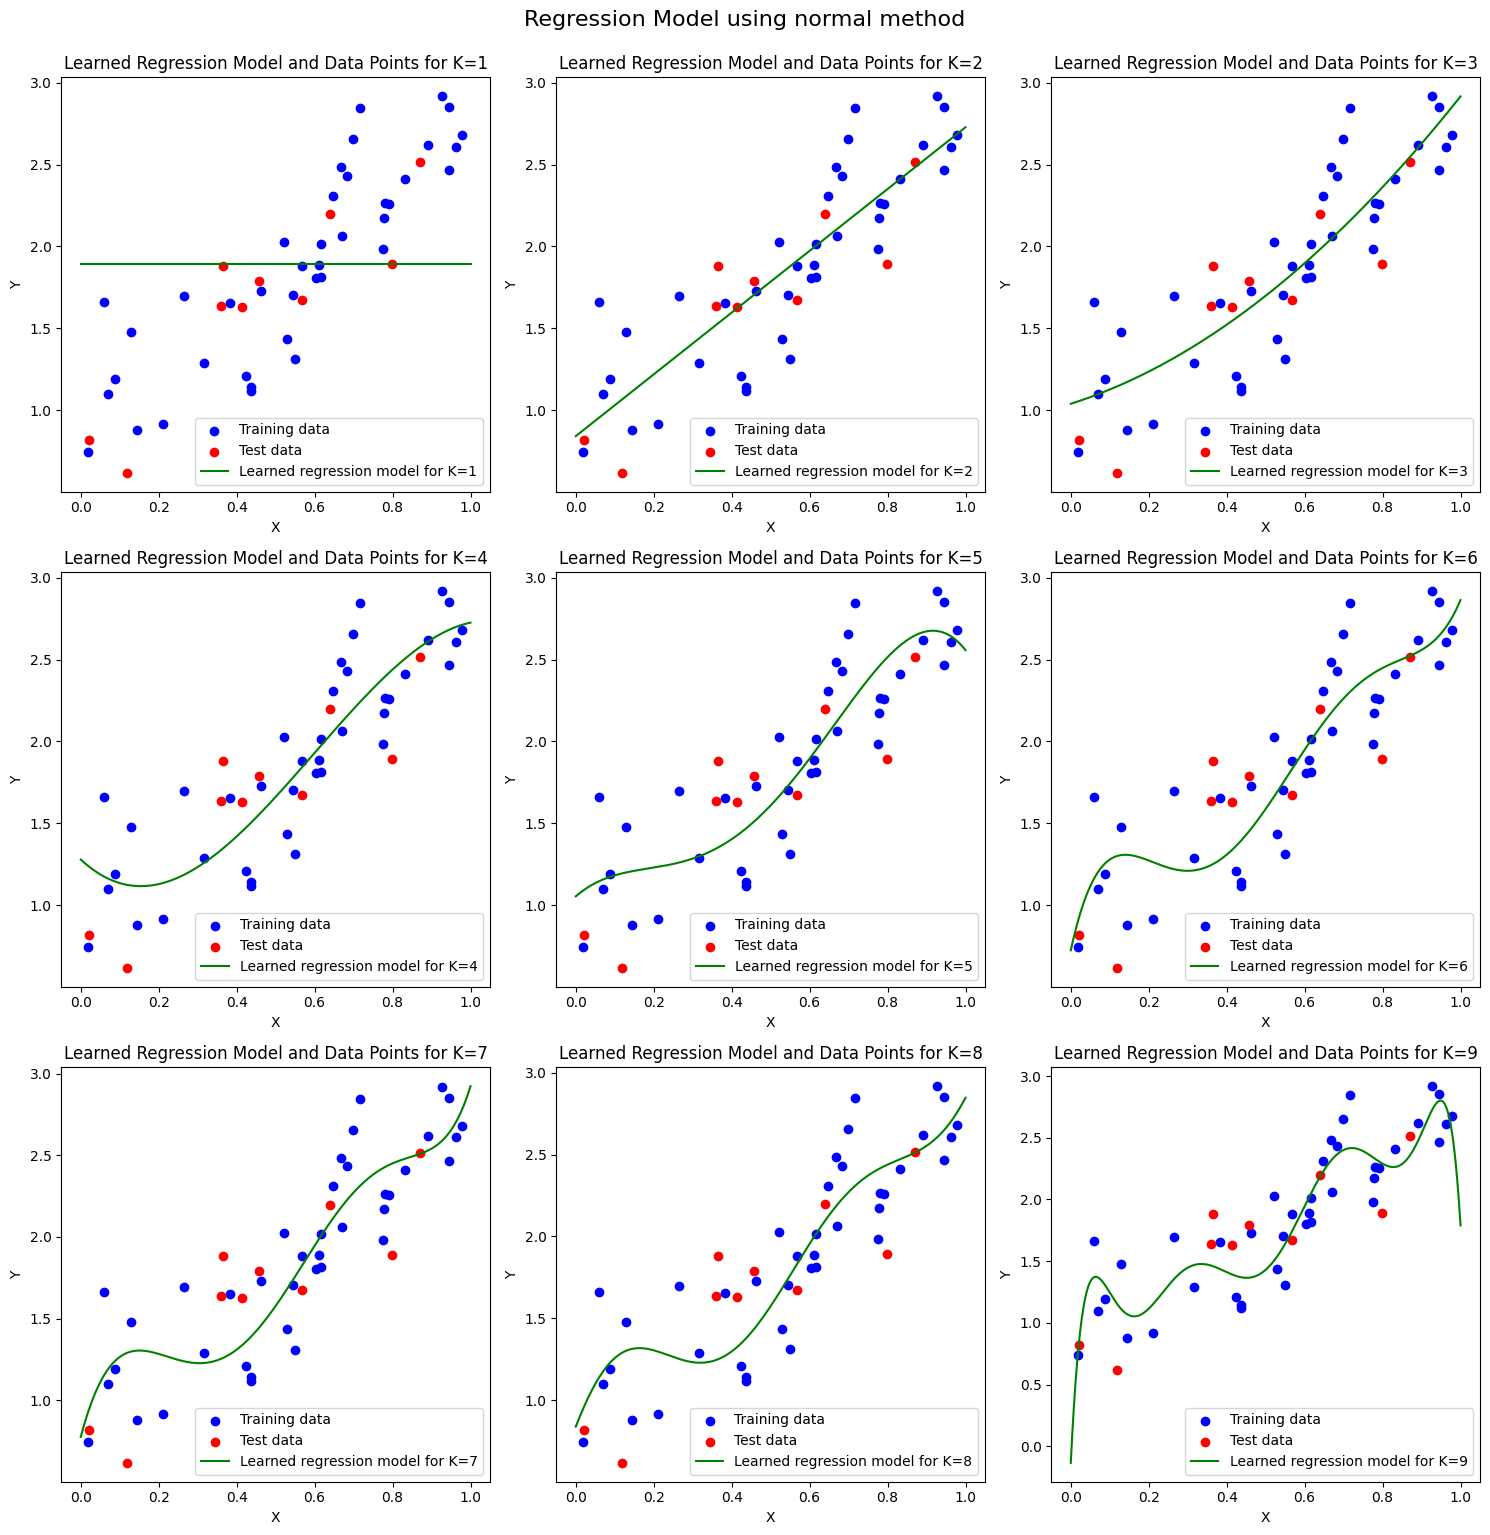

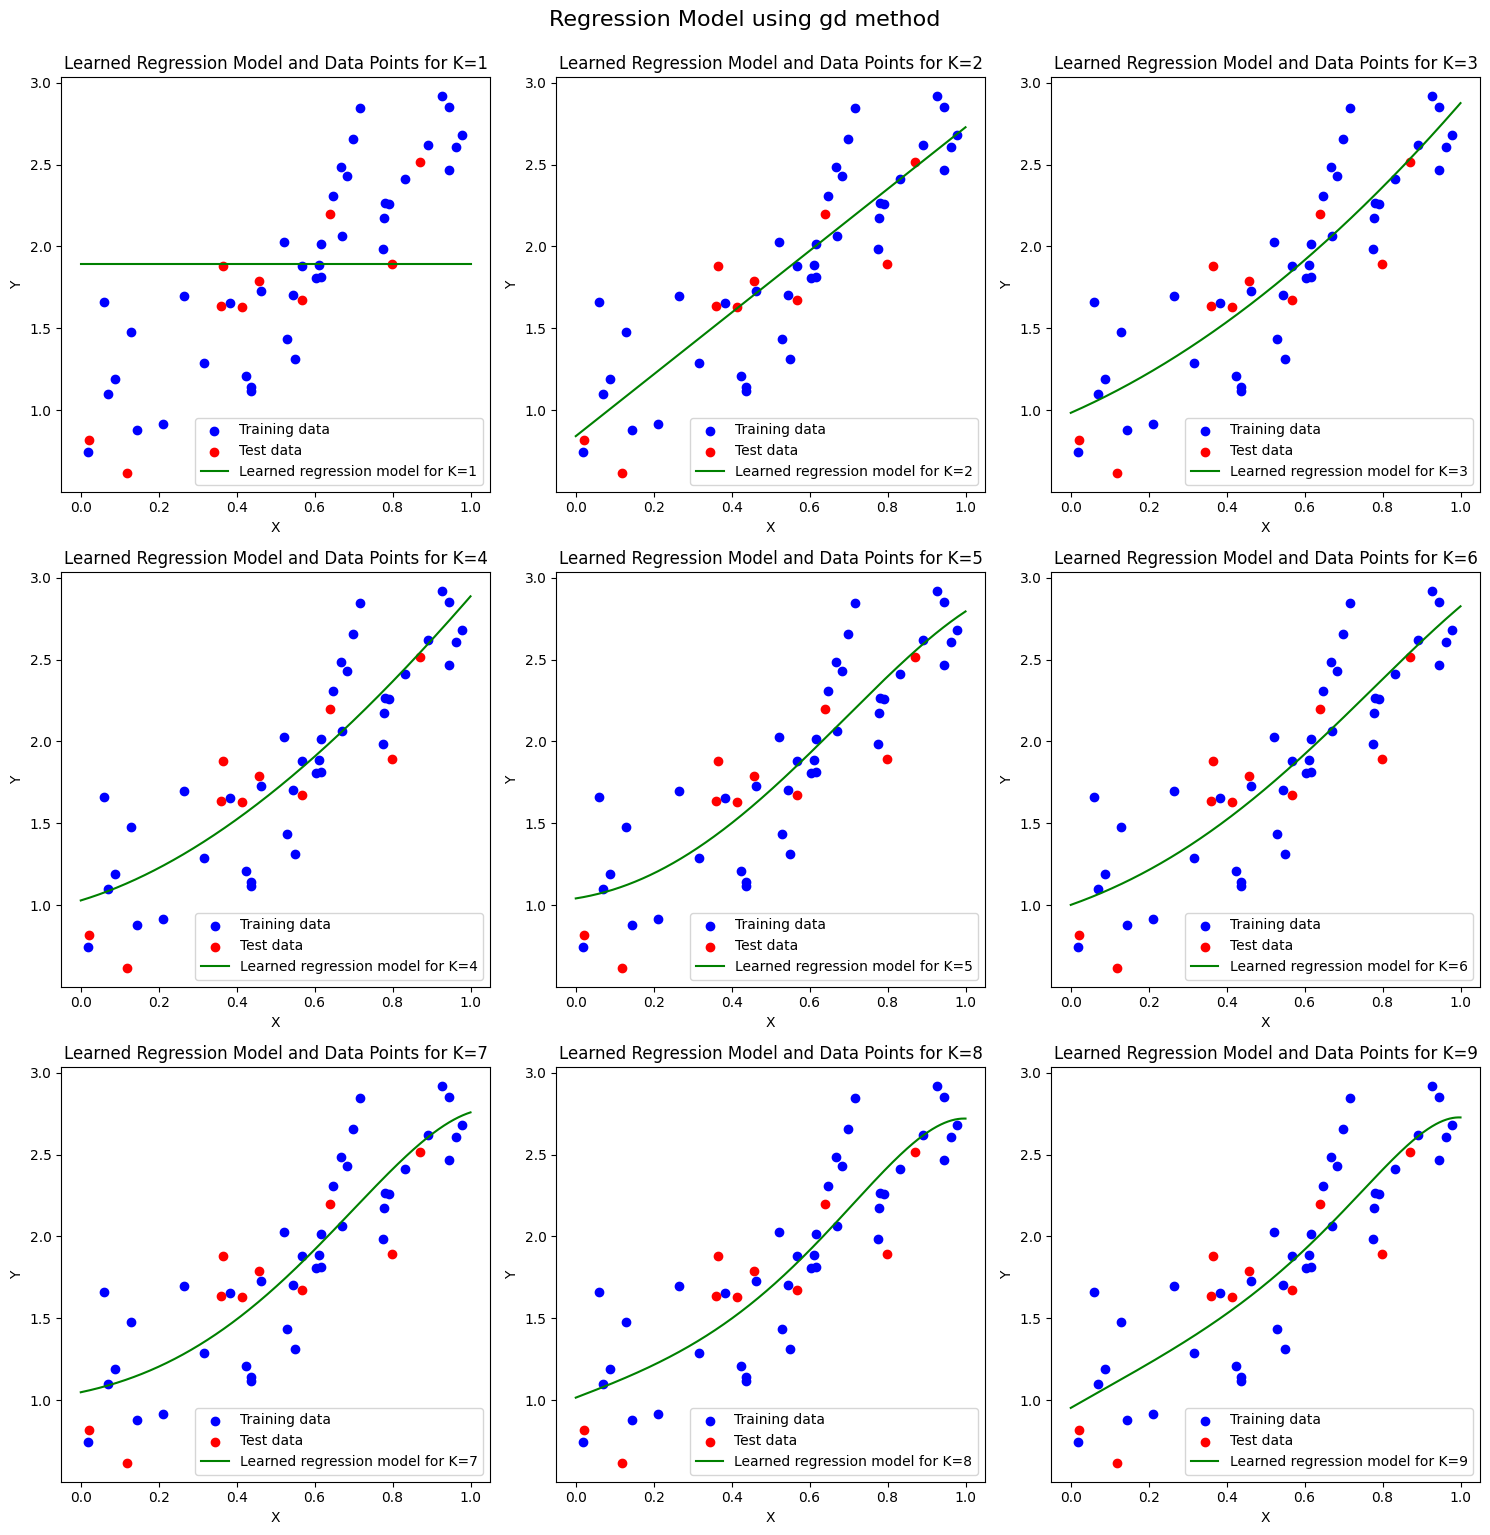

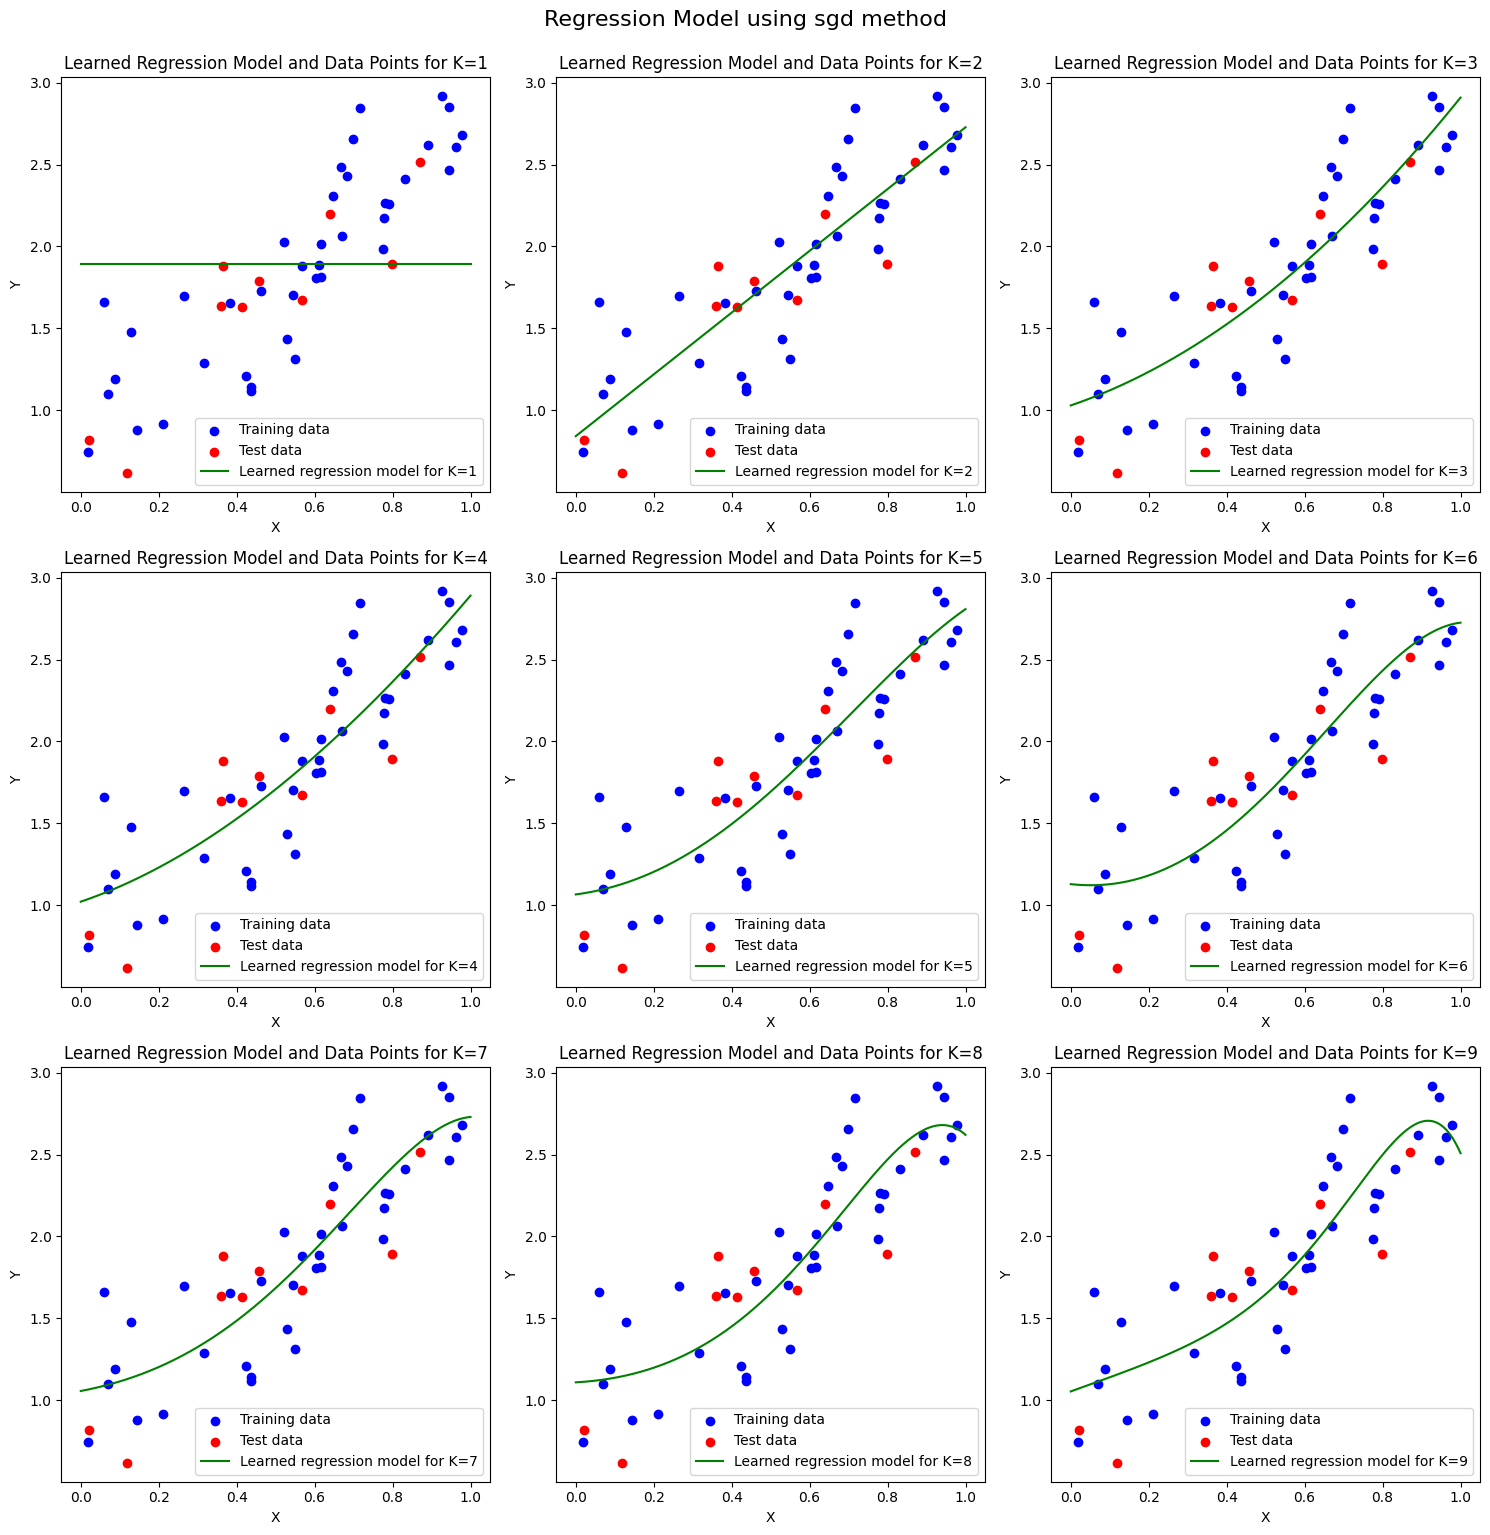

In [77]:
# Create a range of x values for the continuous line plot
x_range = np.linspace(a, b, 1000)

methods = ['normal', 'gd', 'sgd']
for method in methods:
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    axs = axs.ravel()

    for K in range(1, 10):
        Phi_X_train = np.vander(X_train, N=K, increasing=True)
        # Compute the learned regression model fθMLE(x)
        if method == 'normal':
            theta = compute_mle_normal_eq(X_train, Y_train, K)
        elif method == 'gd':
            theta_list, _, _, _, _ = gradient_descent_mle(f_mle, grad_f_mle, np.random.randn(K), 10000, 1e-8, 1e-8, Phi_X_train, Y_train, do_backtracking=False, alpha_value=0.01)
            theta = theta_list[-1]
        elif method == 'sgd':
            theta_list, _, _, _ = stochastic_gradient_descent_mle(f_mle, grad_f_mle, np.random.randn(K), (Phi_X_train, Y_train), 8, 10000,0.01)
            theta = theta_list[-1]

        Phi_X_range = np.vander(x_range, N=K, increasing=True)
        f_theta = Phi_X_range @ theta

        # Plot the training and test data points
        axs[K-1].scatter(X_train, Y_train, color='blue', label='Training data')
        axs[K-1].scatter(X_test, Y_test, color='red', label='Test data')

        # Plot the learned regression model as a continuous line
        axs[K-1].plot(x_range, f_theta, color='green', label=f'Learned regression model for K={K}')

        # Add labels, title, and legend
        axs[K-1].set_xlabel('X')
        axs[K-1].set_ylabel('Y')
        axs[K-1].set_title(f'Learned Regression Model and Data Points for K={K}')
        axs[K-1].legend()

    # Show the plot
    plt.tight_layout()
    plt.suptitle(f'Regression Model using {method} method', fontsize=16, y=1.02)

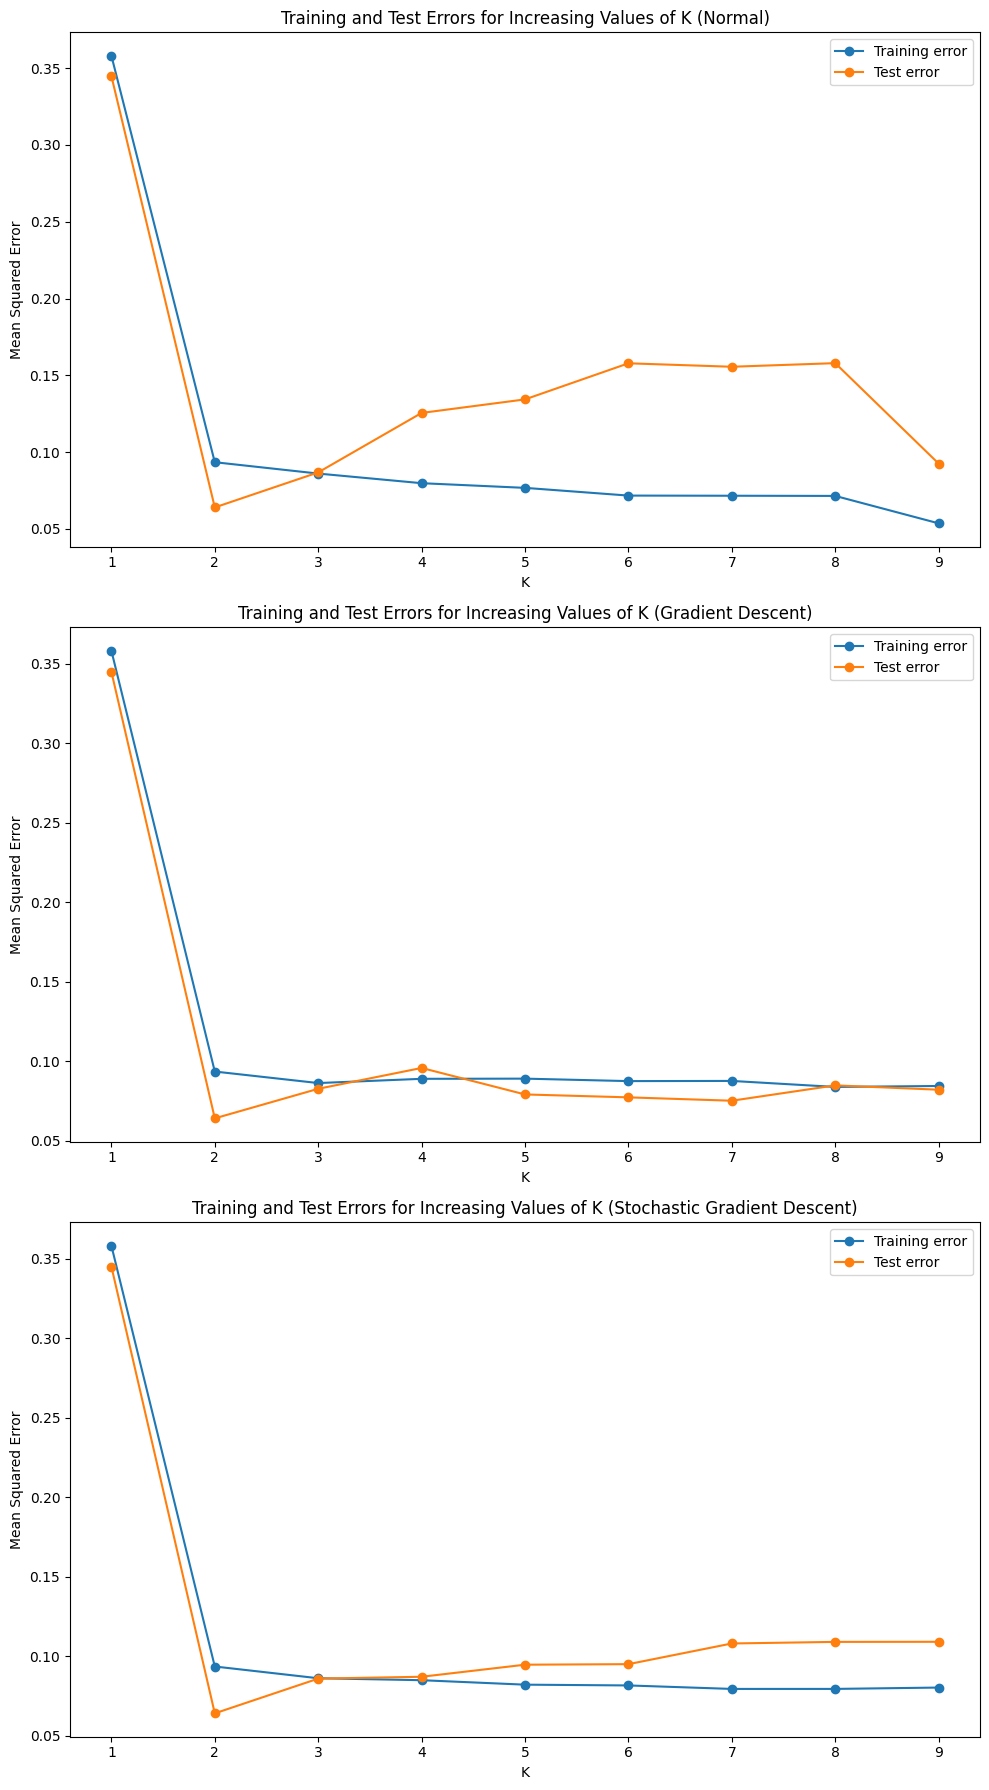

In [78]:
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Normal method
axs[0].plot(range(1, 10), mse_mle_normal_train_list, marker='o', label='Training error')
axs[0].plot(range(1, 10), mse_mle_normal_test_list, marker='o', label='Test error')
axs[0].set_xlabel('K')
axs[0].set_ylabel('Mean Squared Error')
axs[0].set_title('Training and Test Errors for Increasing Values of K (Normal)')
axs[0].legend()

# Gradient Descent method
axs[1].plot(range(1, 10), mse_mle_gd_train_list, marker='o', label='Training error')
axs[1].plot(range(1, 10), mse_mle_gd_test_list, marker='o', label='Test error')
axs[1].set_xlabel('K')
axs[1].set_ylabel('Mean Squared Error')
axs[1].set_title('Training and Test Errors for Increasing Values of K (Gradient Descent)')
axs[1].legend()

# Stochastic Gradient Descent method
axs[2].plot(range(1, 10), mse_mle_sgd_train_list, marker='o', label='Training error')
axs[2].plot(range(1, 10), mse_mle_sgd_test_list, marker='o', label='Test error')
axs[2].set_xlabel('K')
axs[2].set_ylabel('Mean Squared Error')
axs[2].set_title('Training and Test Errors for Increasing Values of K (Stochastic Gradient Descent)')
axs[2].legend()

plt.tight_layout()
plt.show()

### Visualization MAP

In [80]:
mse_map_normal_train_list = {}
mse_map_normal_test_list = {}
mse_map_gd_train_list = {}
mse_map_gd_test_list = {}
mse_map_sgd_train_list = {}
mse_map_sgd_test_list = {}


for lambda_ in [0.1, 10]:
    mse_map_normal_train_list[lambda_] = []
    mse_map_normal_test_list[lambda_] = []
    mse_map_gd_train_list[lambda_] = []
    mse_map_gd_test_list[lambda_] = []
    mse_map_sgd_train_list[lambda_] = []
    mse_map_sgd_test_list[lambda_] = []
    for K in range(1, 10):
        Phi_X_train = np.vander(X_train, N=K, increasing=True)
        Phi_X_test = np.vander(X_test, N=K, increasing=True)
        # Normal Equation
        theta_map_normal = compute_map_normal_eq(X_train, Y_train, K, 0.1)
        # Gradient Descent
        theta_list_map, _, _, _, _ = gradient_descent_map(f_map, grad_f_map, np.random.randn(K), 10000, 1e-8, 1e-8, Phi_X_train, Y_train, do_backtracking=False, alpha_value=0.01, lambda_=0.1)
        theta_map_gd = theta_list_map[-1]
        # Stochastic Gradient Descent
        theta_list_sgd, _, _, _ = stochastic_gradient_descent_map(f_map, grad_f_map, np.random.randn(K), (Phi_X_train, Y_train), 8, 10000,0.01, lambda_=0.1)
        theta_map_sgd = theta_list_sgd[-1]
        
        mse_map_normal_train = MSE(theta_map_normal, Phi_X_train, Y_train, K)
        mse_map_normal_test = MSE(theta_map_normal, Phi_X_test, Y_test, K)
        mse_map_gd_train = MSE(theta_map_gd, Phi_X_train, Y_train, K)
        mse_map_gd_test = MSE(theta_map_gd, Phi_X_test, Y_test, K)
        mse_map_sgd_train = MSE(theta_map_sgd, Phi_X_train, Y_train, K)
        mse_map_sgd_test = MSE(theta_map_sgd, Phi_X_test, Y_test, K)
        
        mse_map_normal_train_list[lambda_].append(mse_map_normal_train)
        mse_map_normal_test_list[lambda_].append(mse_map_normal_test)
        mse_map_gd_train_list[lambda_].append(mse_map_gd_train)
        mse_map_gd_test_list[lambda_].append(mse_map_gd_test)
        mse_map_sgd_train_list[lambda_].append(mse_map_sgd_train)
        mse_map_sgd_test_list[lambda_].append(mse_map_sgd_test)
        

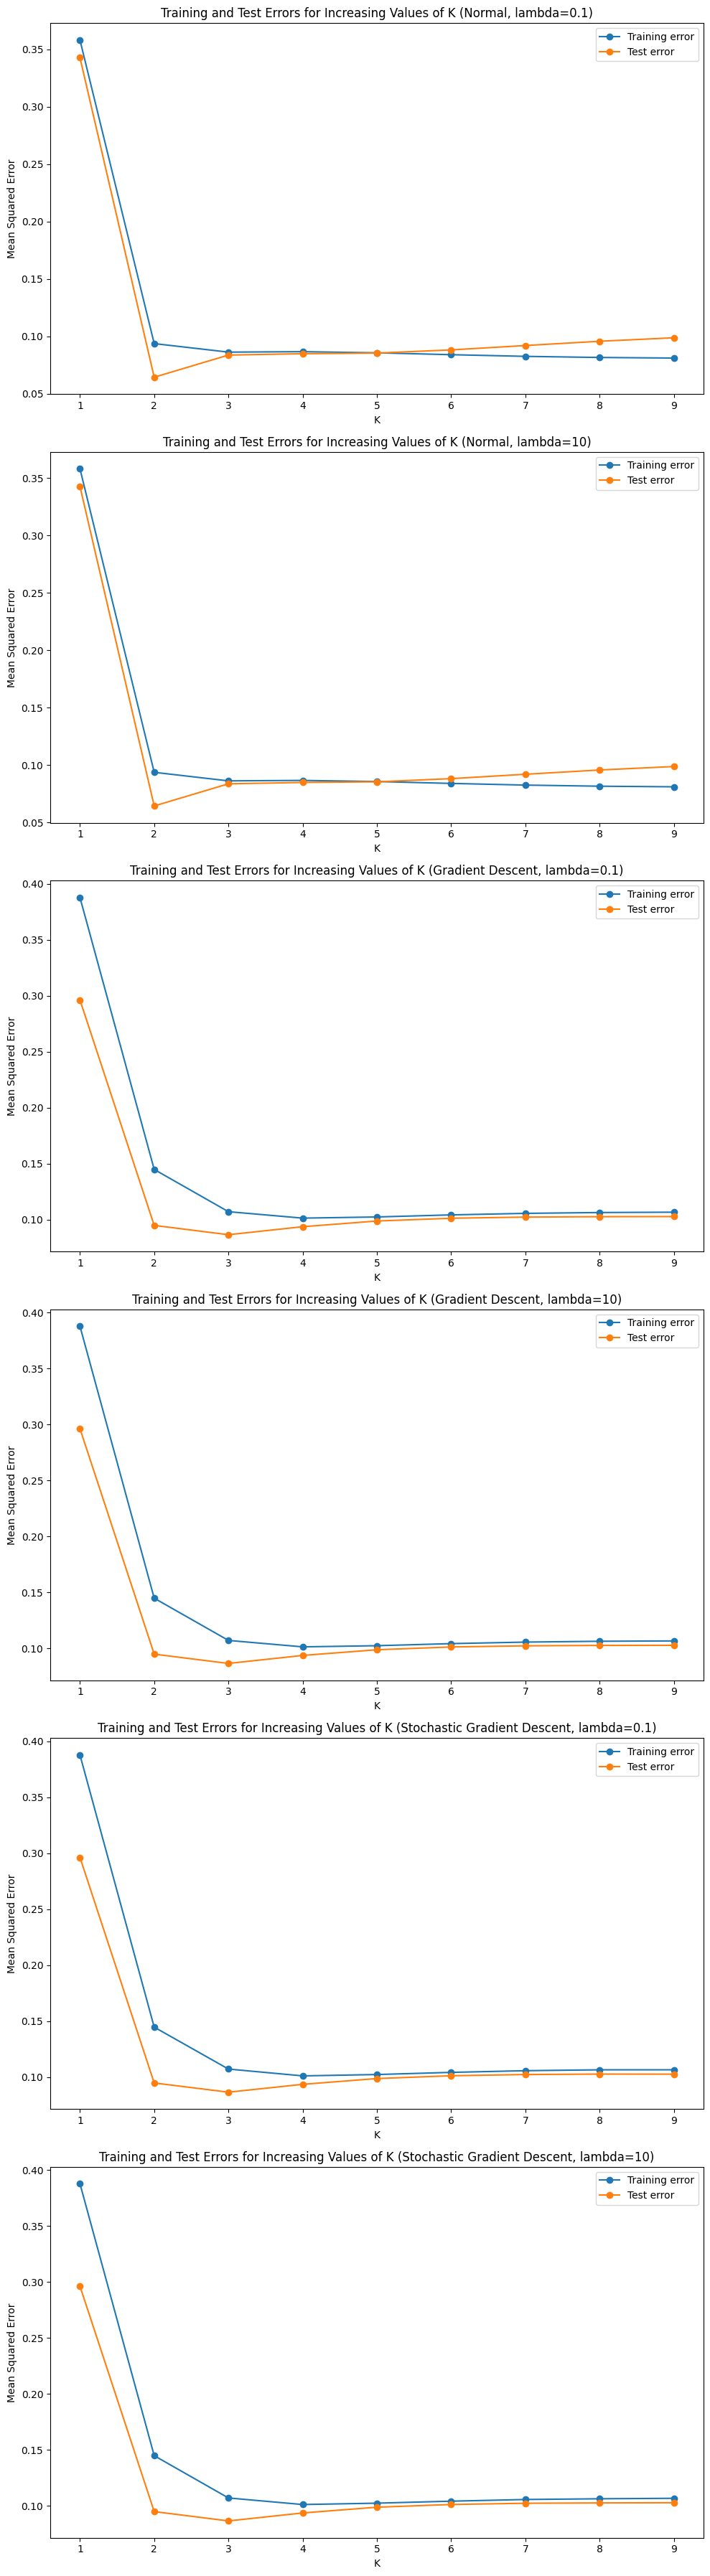

In [83]:
fig, axs = plt.subplots(6, 1, figsize=(10, 36))

# Normal method
for i, lambda_ in enumerate([0.1, 10]):
    axs[i].plot(range(1, 10), mse_map_normal_train_list[lambda_], marker='o', label='Training error')
    axs[i].plot(range(1, 10), mse_map_normal_test_list[lambda_], marker='o', label='Test error')
    axs[i].set_xlabel('K')
    axs[i].set_ylabel('Mean Squared Error')
    axs[i].set_title(f'Training and Test Errors for Increasing Values of K (Normal, lambda={lambda_})')
    axs[i].legend()

# Gradient Descent method
for i, lambda_ in enumerate([0.1, 10], start=2):
    axs[i].plot(range(1, 10), mse_map_gd_train_list[lambda_], marker='o', label='Training error')
    axs[i].plot(range(1, 10), mse_map_gd_test_list[lambda_], marker='o', label='Test error')
    axs[i].set_xlabel('K')
    axs[i].set_ylabel('Mean Squared Error')
    axs[i].set_title(f'Training and Test Errors for Increasing Values of K (Gradient Descent, lambda={lambda_})')
    axs[i].legend()

# Stochastic Gradient Descent method
for i, lambda_ in enumerate([0.1, 10], start=4):
    axs[i].plot(range(1, 10), mse_map_sgd_train_list[lambda_], marker='o', label='Training error')
    axs[i].plot(range(1, 10), mse_map_sgd_test_list[lambda_], marker='o', label='Test error')
    axs[i].set_xlabel('K')
    axs[i].set_ylabel('Mean Squared Error')
    axs[i].set_title(f'Training and Test Errors for Increasing Values of K (Stochastic Gradient Descent, lambda={lambda_})')
    axs[i].legend()

plt.tight_layout()
plt.show()

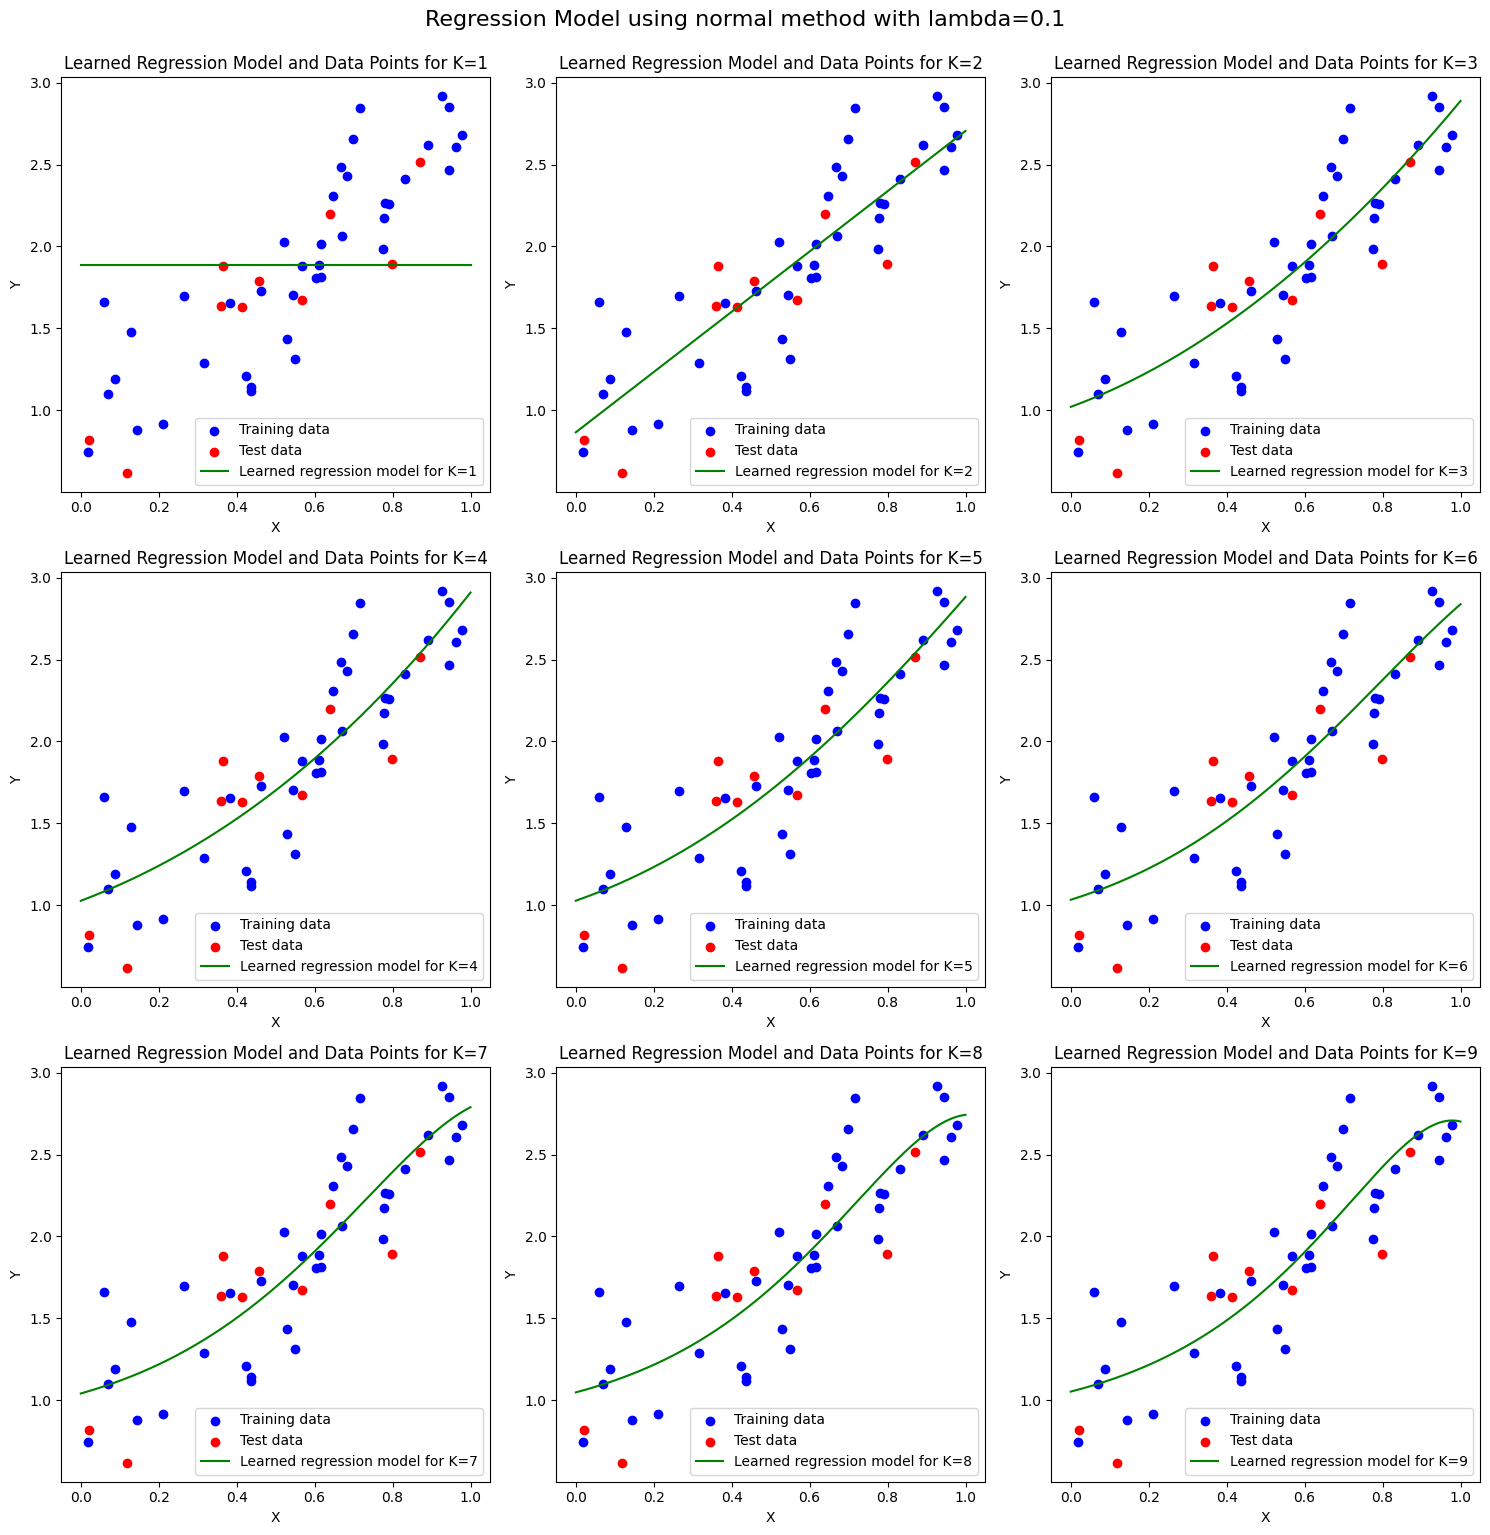

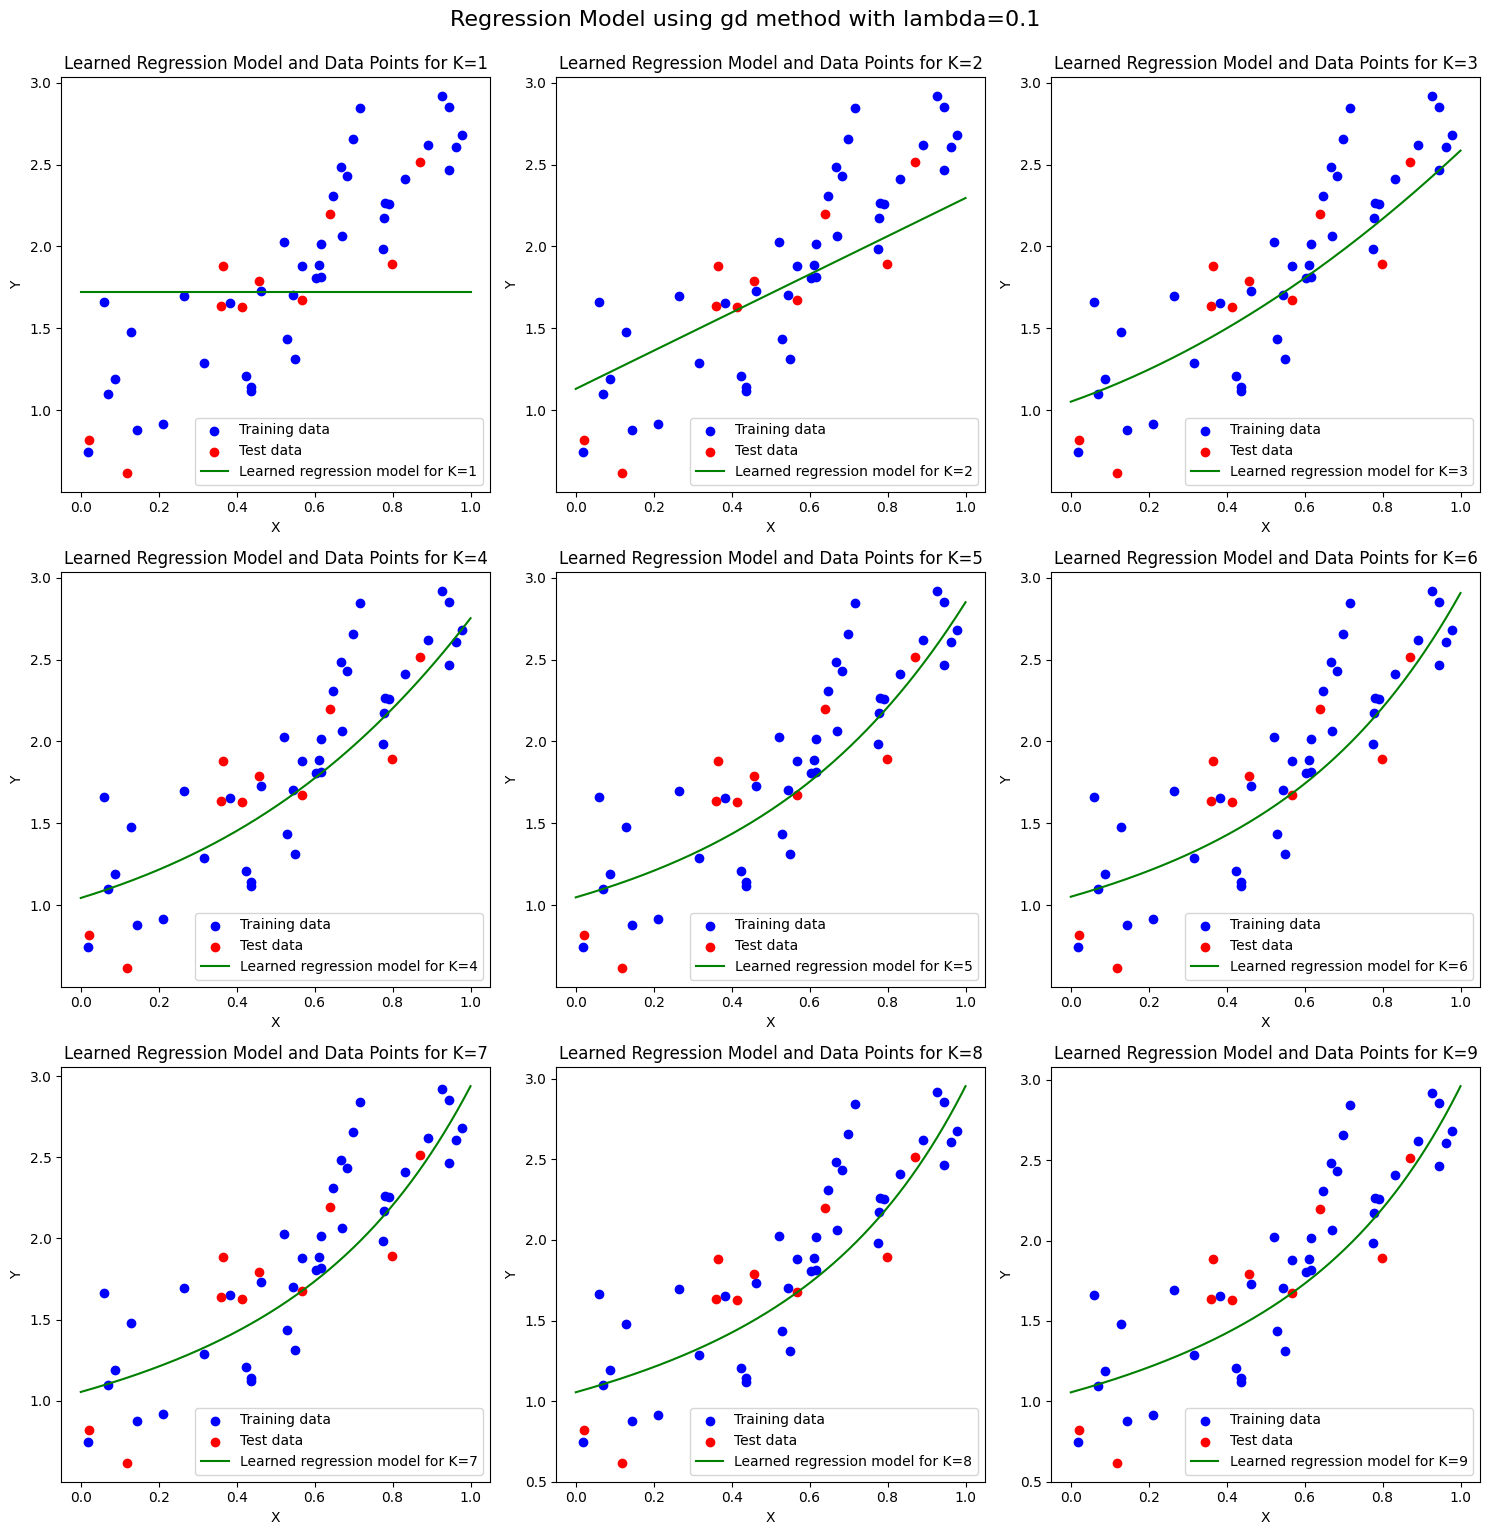

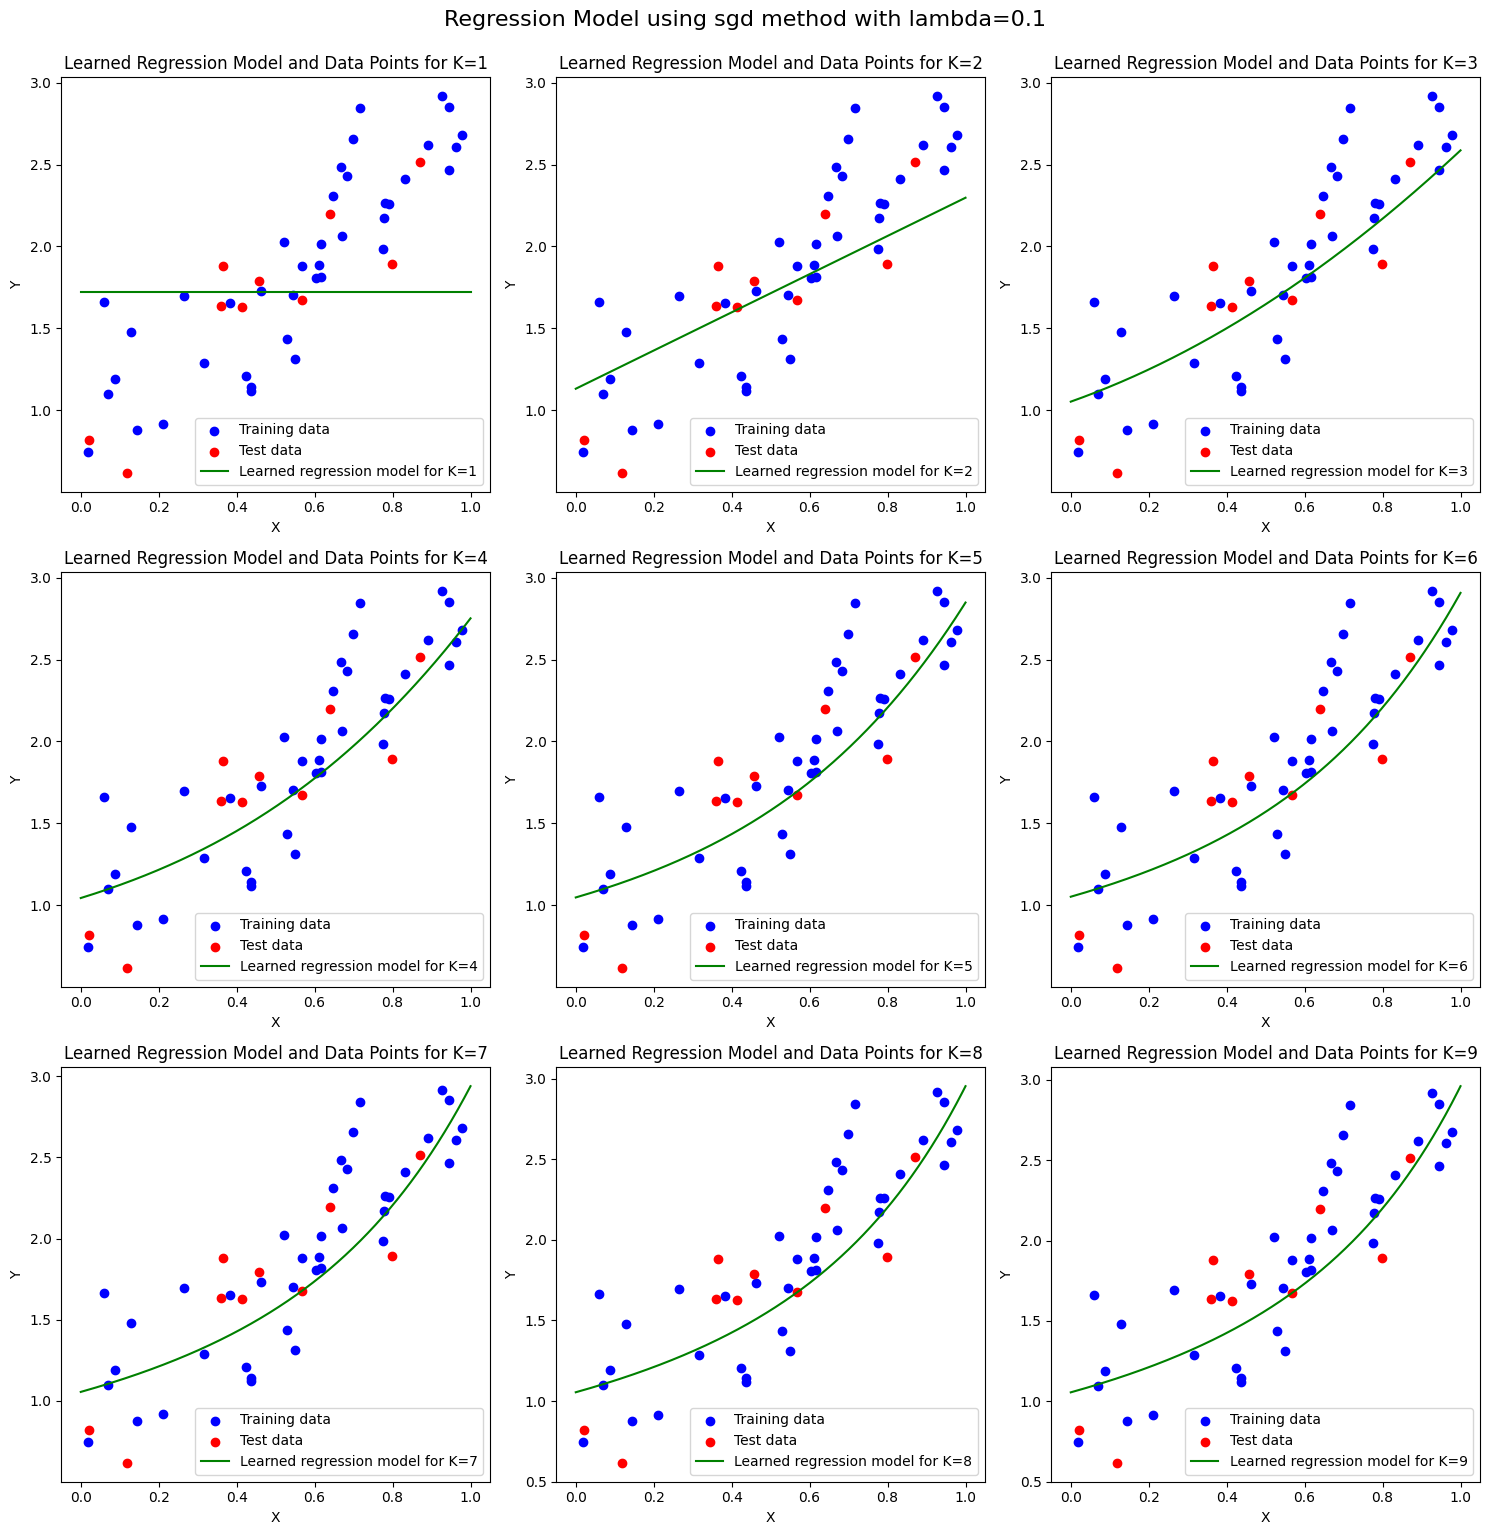

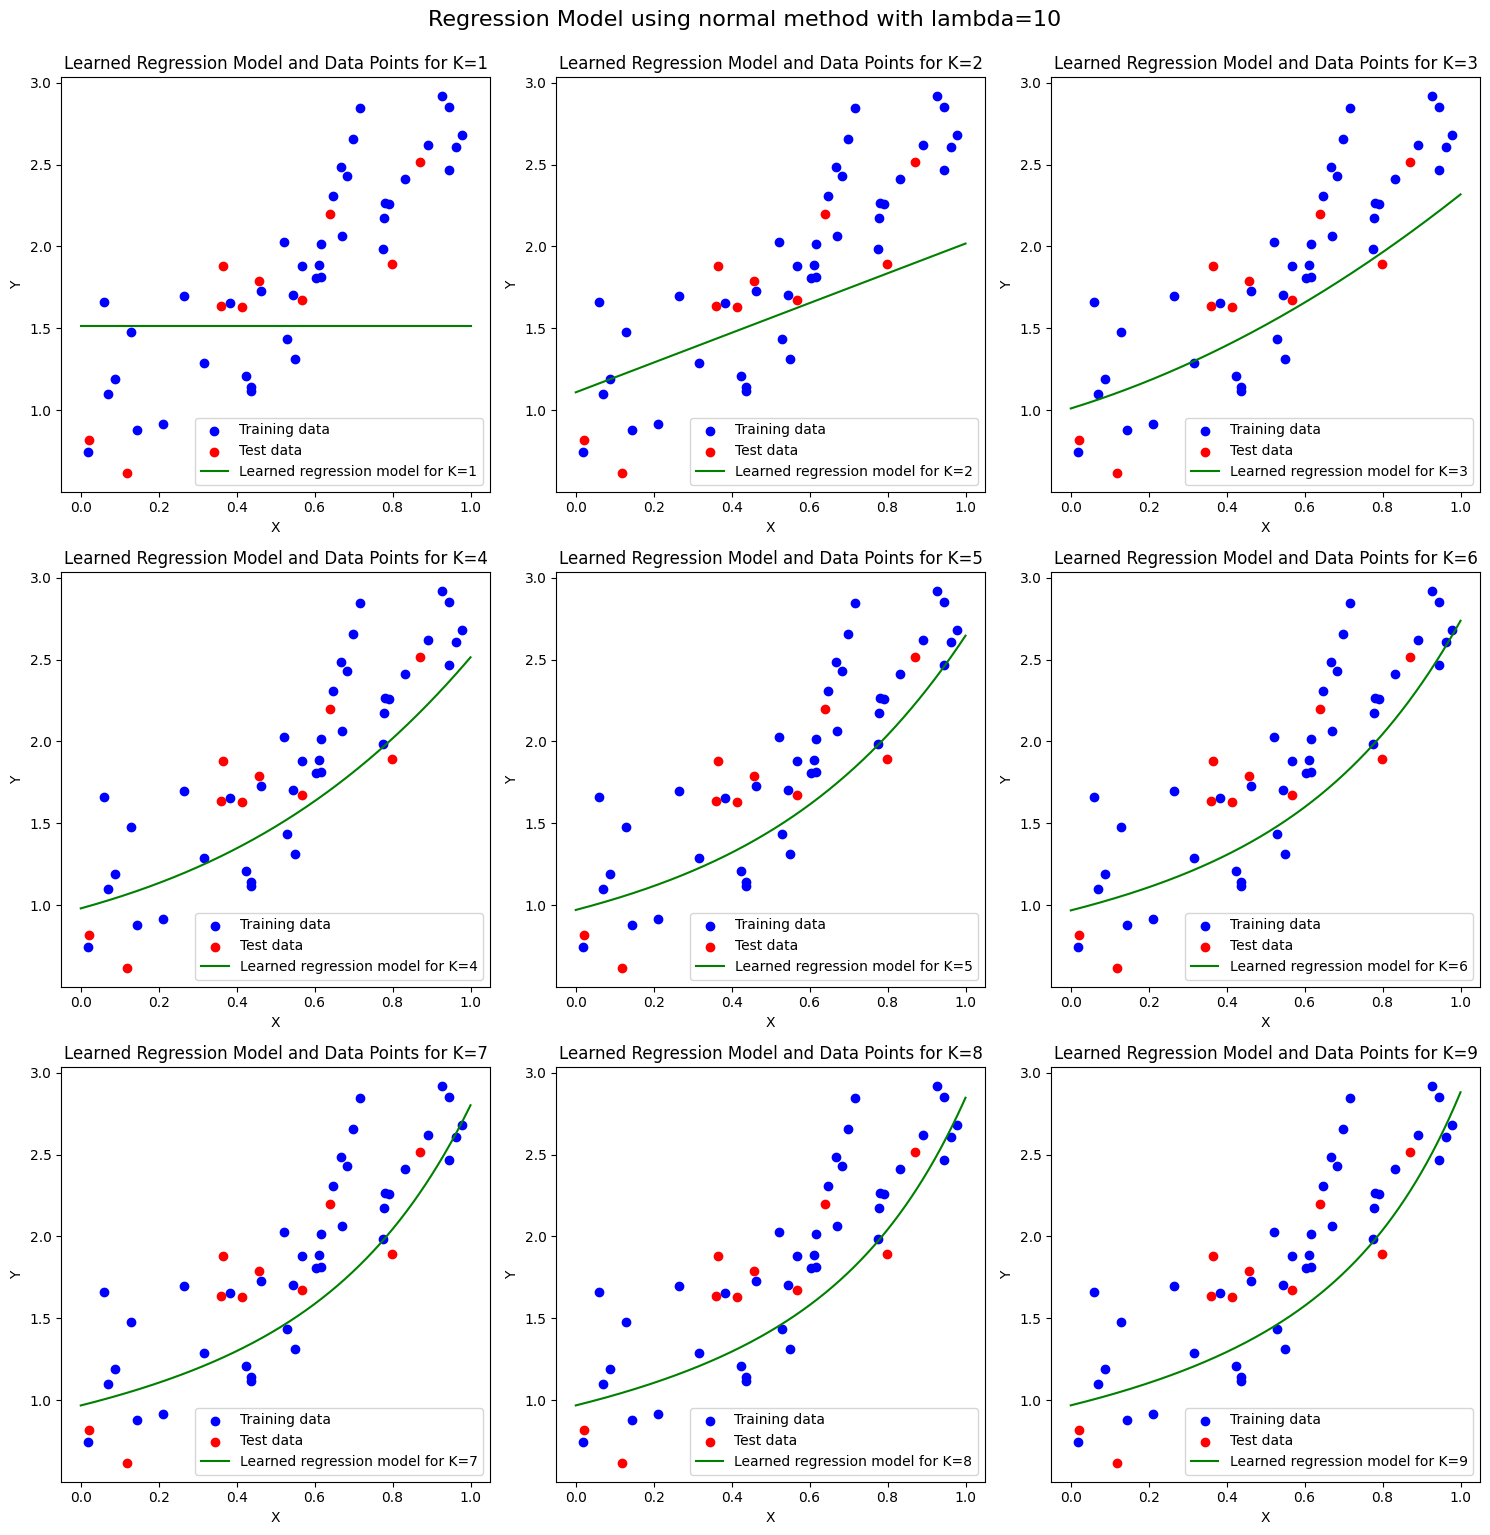

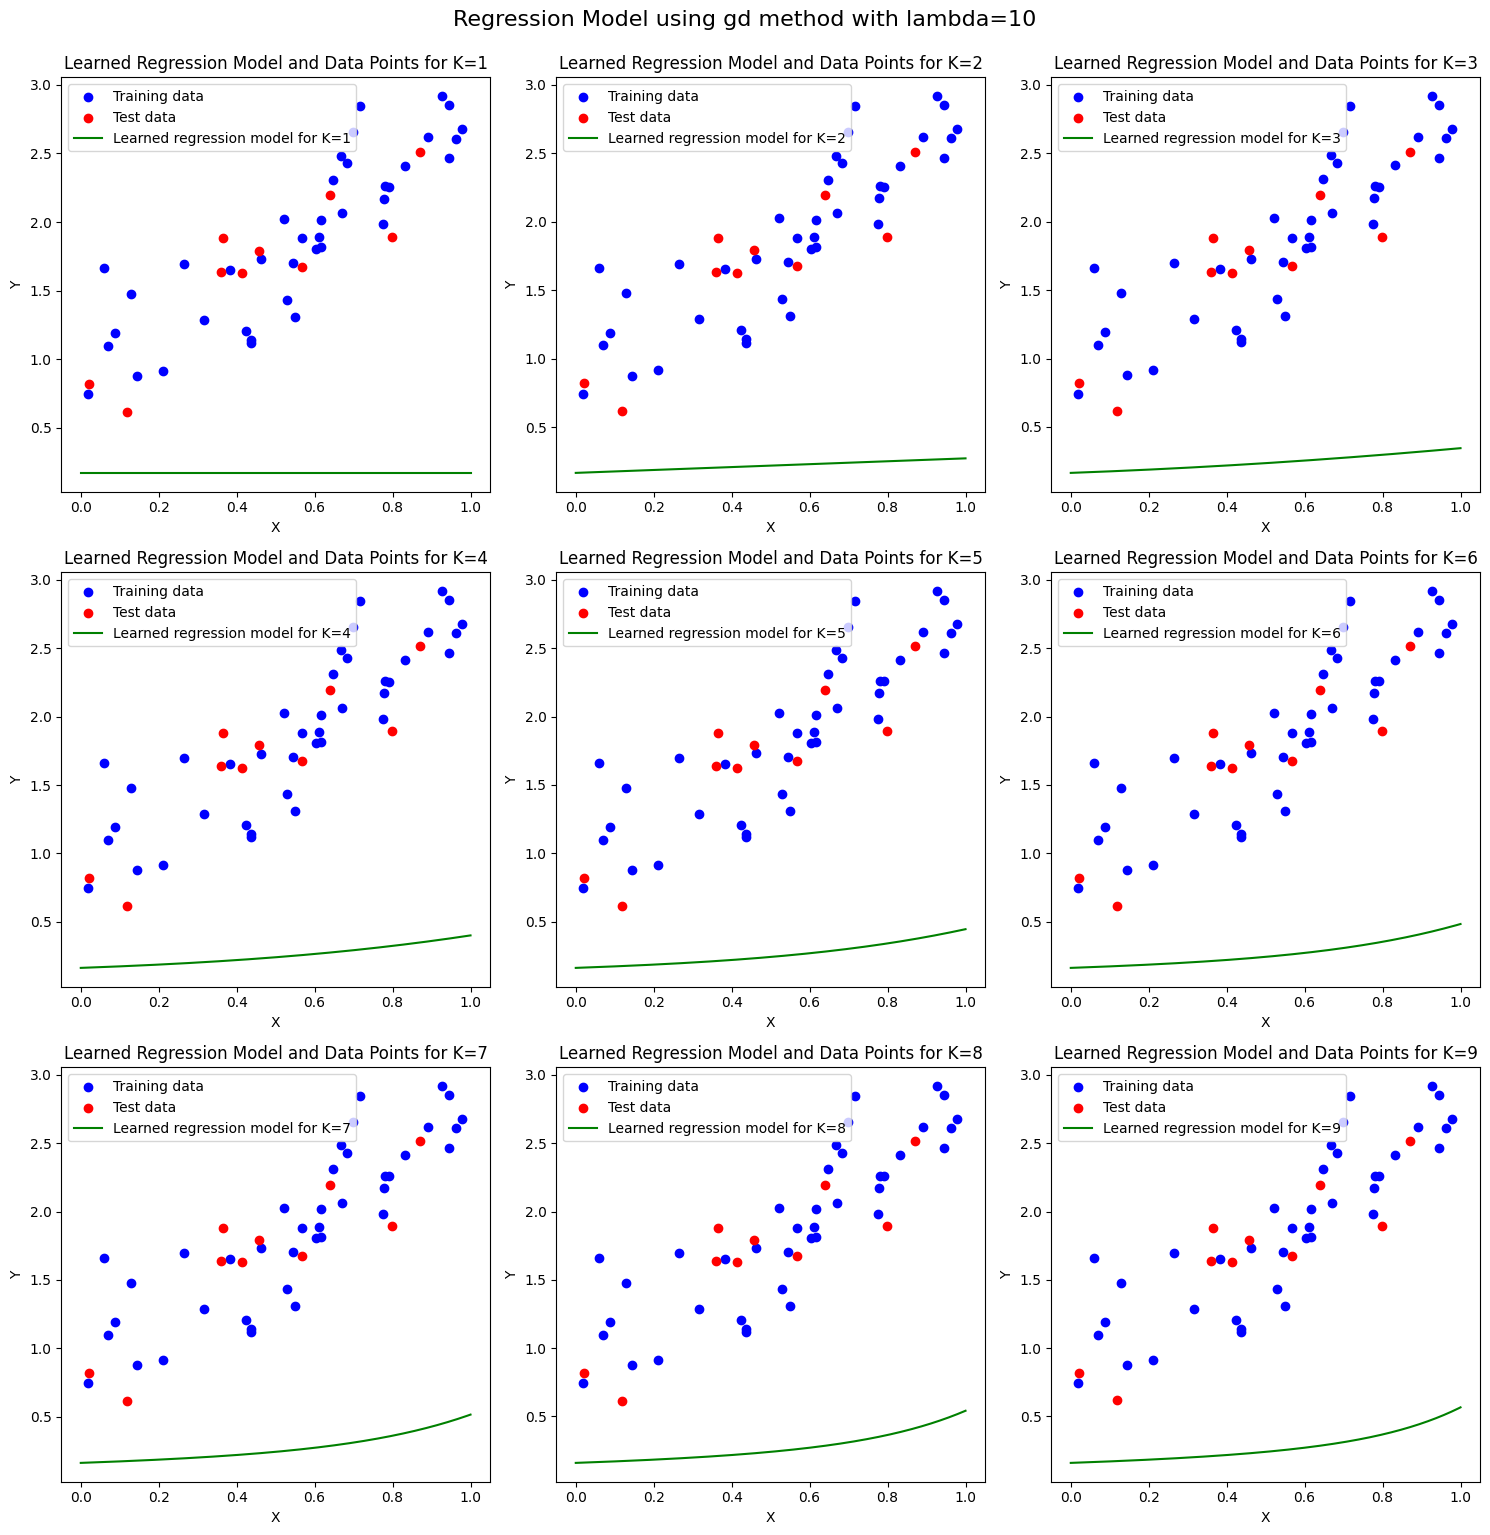

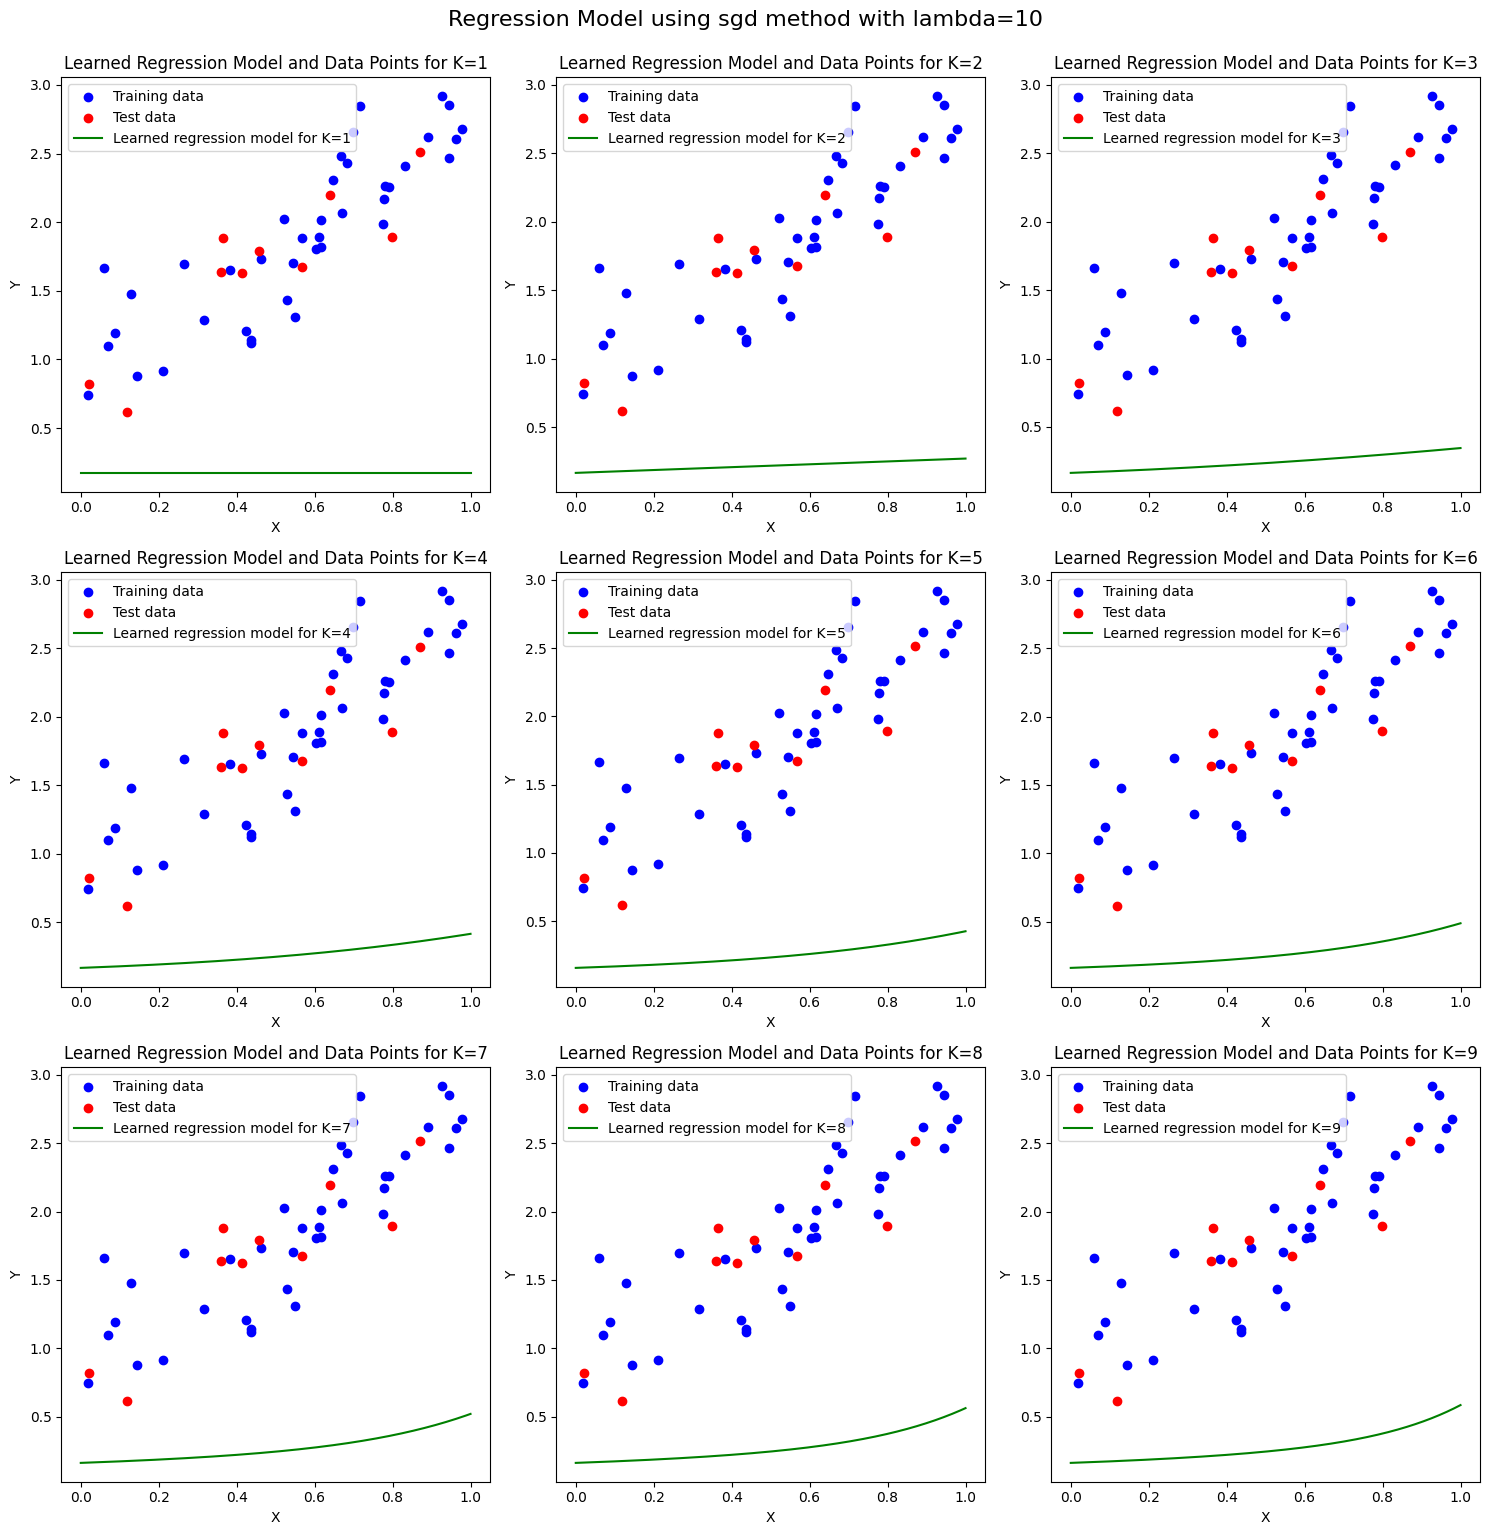

In [85]:
# Create a range of x values for the continuous line plot
x_range = np.linspace(a, b, 1000)

methods = ['normal', 'gd', 'sgd']
lambdas = [0.1, 10]

for lambda_ in lambdas:
    for method in methods:
        fig, axs = plt.subplots(3, 3, figsize=(15, 15))
        axs = axs.ravel()

        for K in range(1, 10):
            Phi_X_train = np.vander(X_train, N=K, increasing=True)
            # Compute the learned regression model fθMLE(x)
            if method == 'normal':
                theta = compute_map_normal_eq(X_train, Y_train, K, lambda_)
            elif method == 'gd':
                theta_list, _, _, _, _ = gradient_descent_map(f_map, grad_f_map, np.random.randn(K), 10000, 1e-8, 1e-8, Phi_X_train, Y_train, do_backtracking=False, alpha_value=0.01, lambda_=lambda_)
                theta = theta_list[-1]
            elif method == 'sgd':
                theta_list, _, _, _ = stochastic_gradient_descent_map(f_map, grad_f_map, np.random.randn(K), (Phi_X_train, Y_train), 8, 10000,0.01, lambda_=lambda_)
                theta = theta_list[-1]

            Phi_X_range = np.vander(x_range, N=K, increasing=True)
            f_theta = Phi_X_range @ theta

            # Plot the training and test data points
            axs[K-1].scatter(X_train, Y_train, color='blue', label='Training data')
            axs[K-1].scatter(X_test, Y_test, color='red', label='Test data')

            # Plot the learned regression model as a continuous line
            axs[K-1].plot(x_range, f_theta, color='green', label=f'Learned regression model for K={K}')

            # Add labels, title, and legend
            axs[K-1].set_xlabel('X')
            axs[K-1].set_ylabel('Y')
            axs[K-1].set_title(f'Learned Regression Model and Data Points for K={K}')
            axs[K-1].legend()

        # Show the plot
        plt.tight_layout()
        plt.suptitle(f'Regression Model using {method} method with lambda={lambda_}', fontsize=16, y=1.02)
        plt.show()

In [87]:
# Set K to a value greater than the correct degree
K = 20

Phi_X_test = np.vander(X_test, N=K, increasing=True)
# Compute the MLE solution
theta_mle = compute_mle_normal_eq(X_train, Y_train, K)


# Compute the test error for the MLE solution
mse_mle_test = MSE(theta_mle, Phi_X_test, Y_test, K)

# Print the test error for the MLE solution
print(f"Test error for MLE solution: {mse_mle_test}")

# Define a list of different lambda values
lambdas = [0.1, 1, 10, 100]

# Compute the MAP solution and test error for each lambda value
for lambda_ in lambdas:
    theta_map = compute_map_normal_eq(X_train, Y_train, K, lambda_)
    mse_map_test = MSE(theta_map, Phi_X_test, Y_test, K)
    print(f"Test error for MAP solution with lambda={lambda_}: {mse_map_test}")

Test error for MLE solution: 349.9925715496524
Test error for MAP solution with lambda=0.1: 0.10445870881985149
Test error for MAP solution with lambda=1: 0.0966505850769358
Test error for MAP solution with lambda=10: 0.14566909549760534
Test error for MAP solution with lambda=100: 1.1117435720873956


In [90]:
def Err(theta, theta_true):
    theta_true_padded = np.pad(theta_true, (0, len(theta) - len(theta_true)))
    return np.linalg.norm(theta - theta_true_padded) / np.linalg.norm(theta_true_padded)

Err_mle = {}
Err_map = {}

K_values = range(4, 21)  
lambdas = [0.1, 1, 10, 100]

for K in K_values:
    theta_mle = compute_mle_normal_eq(X_train, Y_train, K)
    Err_mle[K] = Err(theta_mle, theta_true)
    for lambda_ in lambdas:
        theta_map = compute_map_normal_eq(X_train, Y_train, K, lambda_)
        Err_map[(K, lambda_)] = Err(theta_map, theta_true)

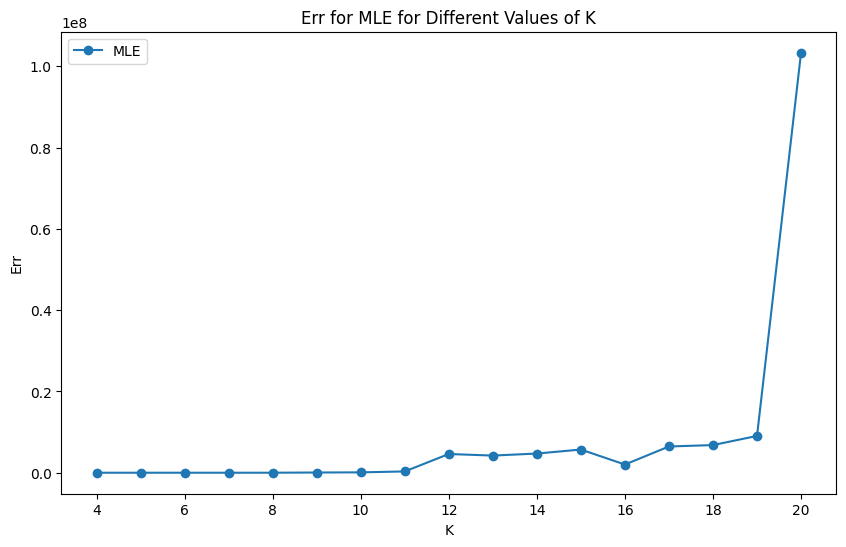

In [93]:
import matplotlib.pyplot as plt

# Extract the Err values for MLE and MAP
err_mle_values = list(Err_mle.values())
err_map_values = {lambda_: [Err_map[(K, lambda_)] for K in K_values] for lambda_ in lambdas}

# Create the plot for MLE
plt.figure(figsize=(10, 6))
plt.plot(K_values, err_mle_values, marker='o', label='MLE')

# Add labels, title, and legend
plt.xlabel('K')
plt.ylabel('Err')
plt.title('Err for MLE for Different Values of K')
plt.legend()

# Show the plot
plt.show()

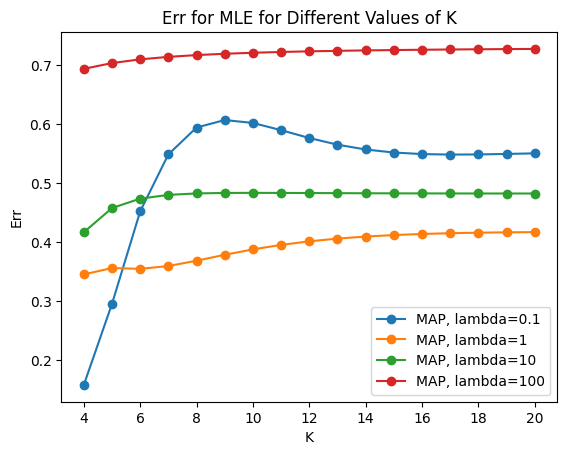

In [94]:
# Create the plots for MAP
for lambda_, err_values in err_map_values.items():
    plt.plot(K_values, err_values, marker='o', label=f'MAP, lambda={lambda_}')

# Add labels, title, and legend
plt.xlabel('K')
plt.ylabel('Err')
plt.title('Err for MAP for Different Values of K')
plt.legend()

# Show the plot
plt.show()

### Run for N = 1000

In [108]:
N = 1000
K = 3

X_train, Y_train, X_test, Y_test, theta_true = produce_data(K, N, a, b, sigma2, seed=0)


In [109]:
mse_mle_normal_train_list = []
mse_mle_normal_test_list = []
mse_mle_gd_train_list = []
mse_mle_gd_test_list = []
mse_mle_sgd_train_list = []
mse_mle_sgd_test_list = []

for K in range(1, 10):
    Phi_X_train = np.vander(X_train, N=K, increasing=True)
    Phi_X_test = np.vander(X_test, N=K, increasing=True)
    # Normal Equation
    theta_mle_normal = compute_mle_normal_eq(X_train, Y_train, K)
    # Gradient Descent
    theta_list, _, _, _, _= gradient_descent_mle(f_mle, grad_f_mle, np.random.randn(K), 10000, 1e-8, 1e-8, Phi_X_train, Y_train, do_backtracking=False, alpha_value=0.01)
    theta_mle_gd = theta_list[-1]
    # Stochastic Gradient Descent
    theta_list_sgd, _, _, _= stochastic_gradient_descent_mle(f_mle, grad_f_mle, np.random.randn(K), (Phi_X_train, Y_train), 64, 10000,0.01)
    theta_mle_sgd = theta_list_sgd[-1]
    
    mse_mle_normal_test = MSE(theta_mle_normal, Phi_X_test, Y_test, K)
    mse_mle_normal_train = MSE(theta_mle_normal, Phi_X_train, Y_train, K)
    mse_mle_gd_train = MSE(theta_mle_gd, Phi_X_train, Y_train, K)
    mse_mle_gd_test = MSE(theta_mle_gd, Phi_X_test, Y_test, K)
    mse_mle_sgd_train = MSE(theta_mle_sgd, Phi_X_train, Y_train, K)
    mse_mle_sgd_test = MSE(theta_mle_sgd, Phi_X_test, Y_test, K)
    
    mse_mle_normal_train_list.append(mse_mle_normal_train)
    mse_mle_normal_test_list.append(mse_mle_normal_test)
    mse_mle_gd_train_list.append(mse_mle_gd_train)
    mse_mle_gd_test_list.append(mse_mle_gd_test)
    mse_mle_sgd_train_list.append(mse_mle_sgd_train)
    mse_mle_sgd_test_list.append(mse_mle_sgd_test)

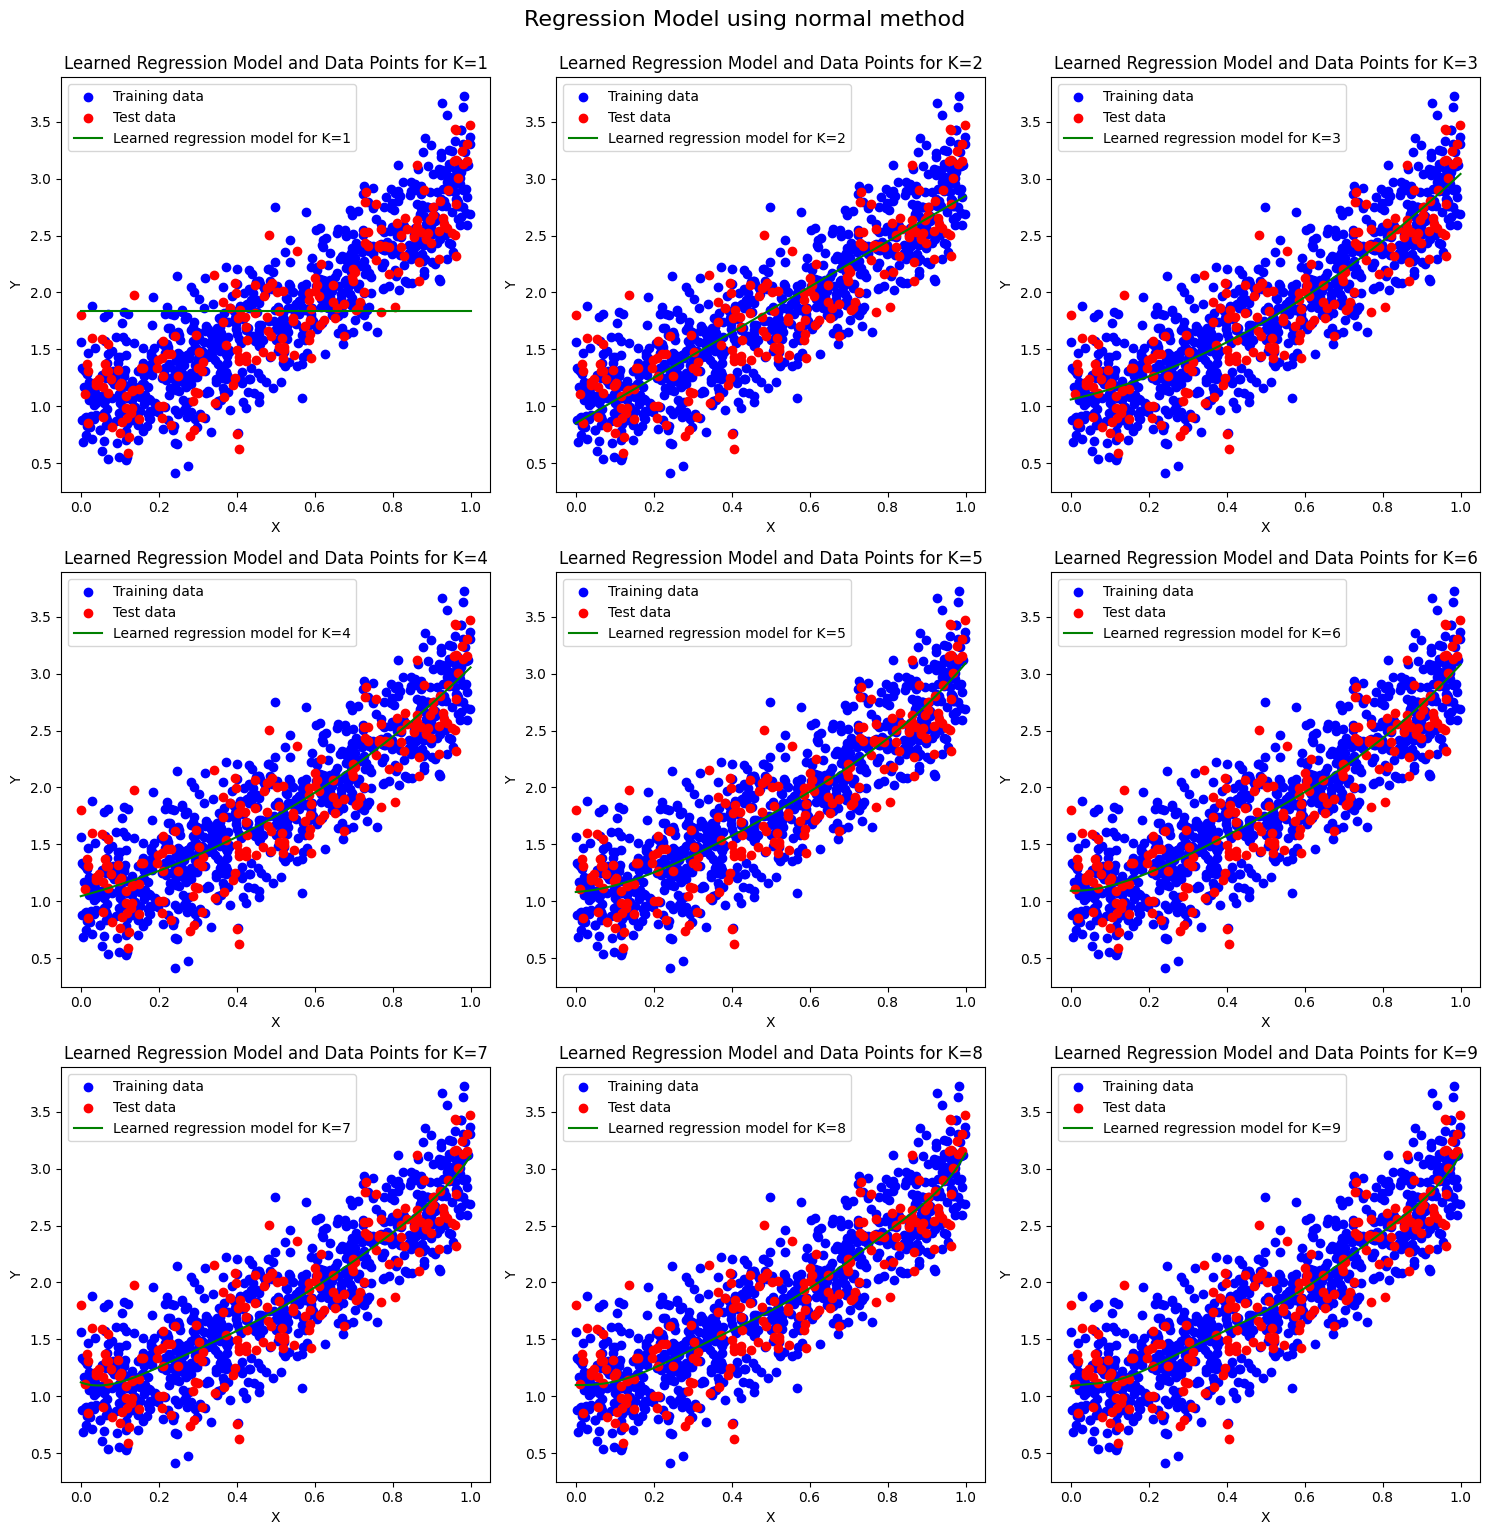

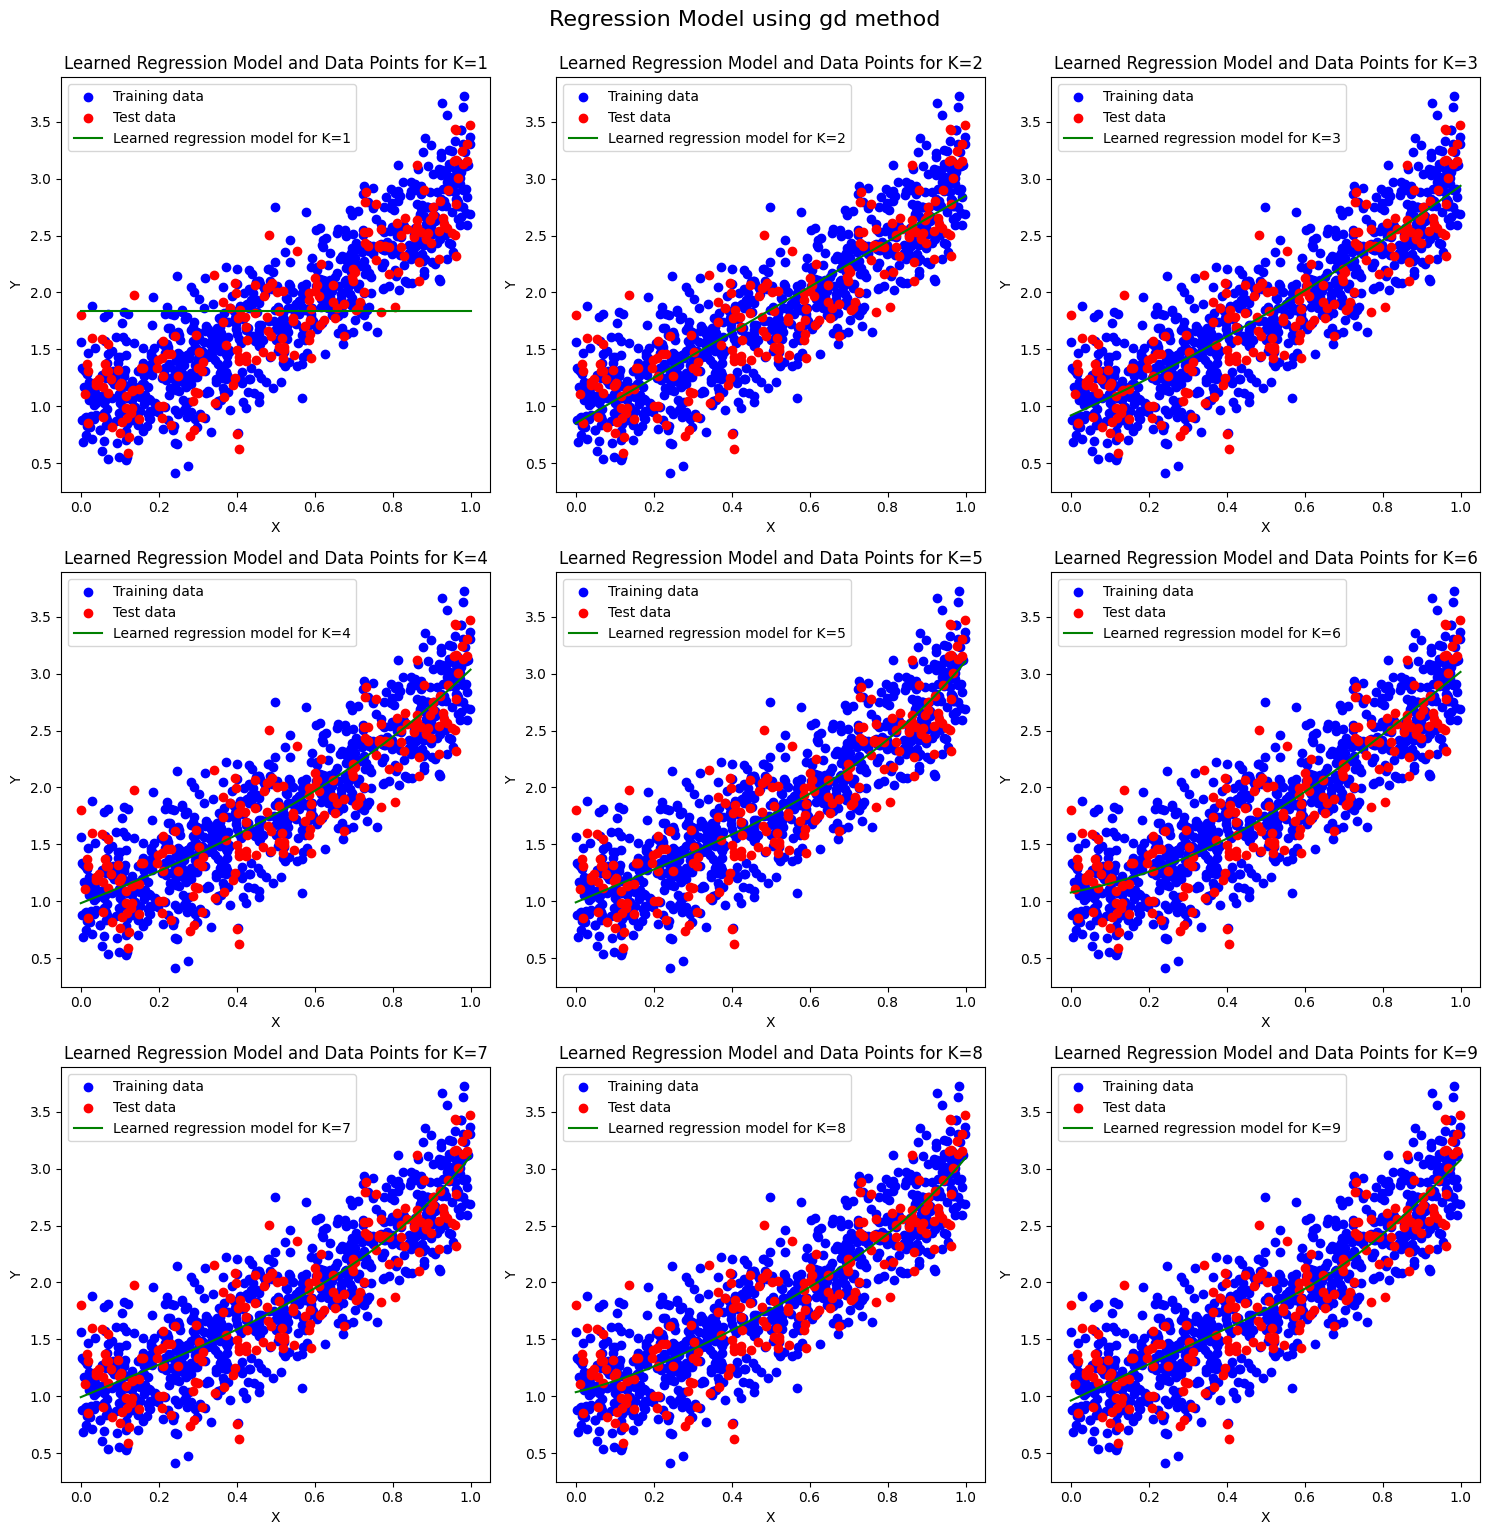

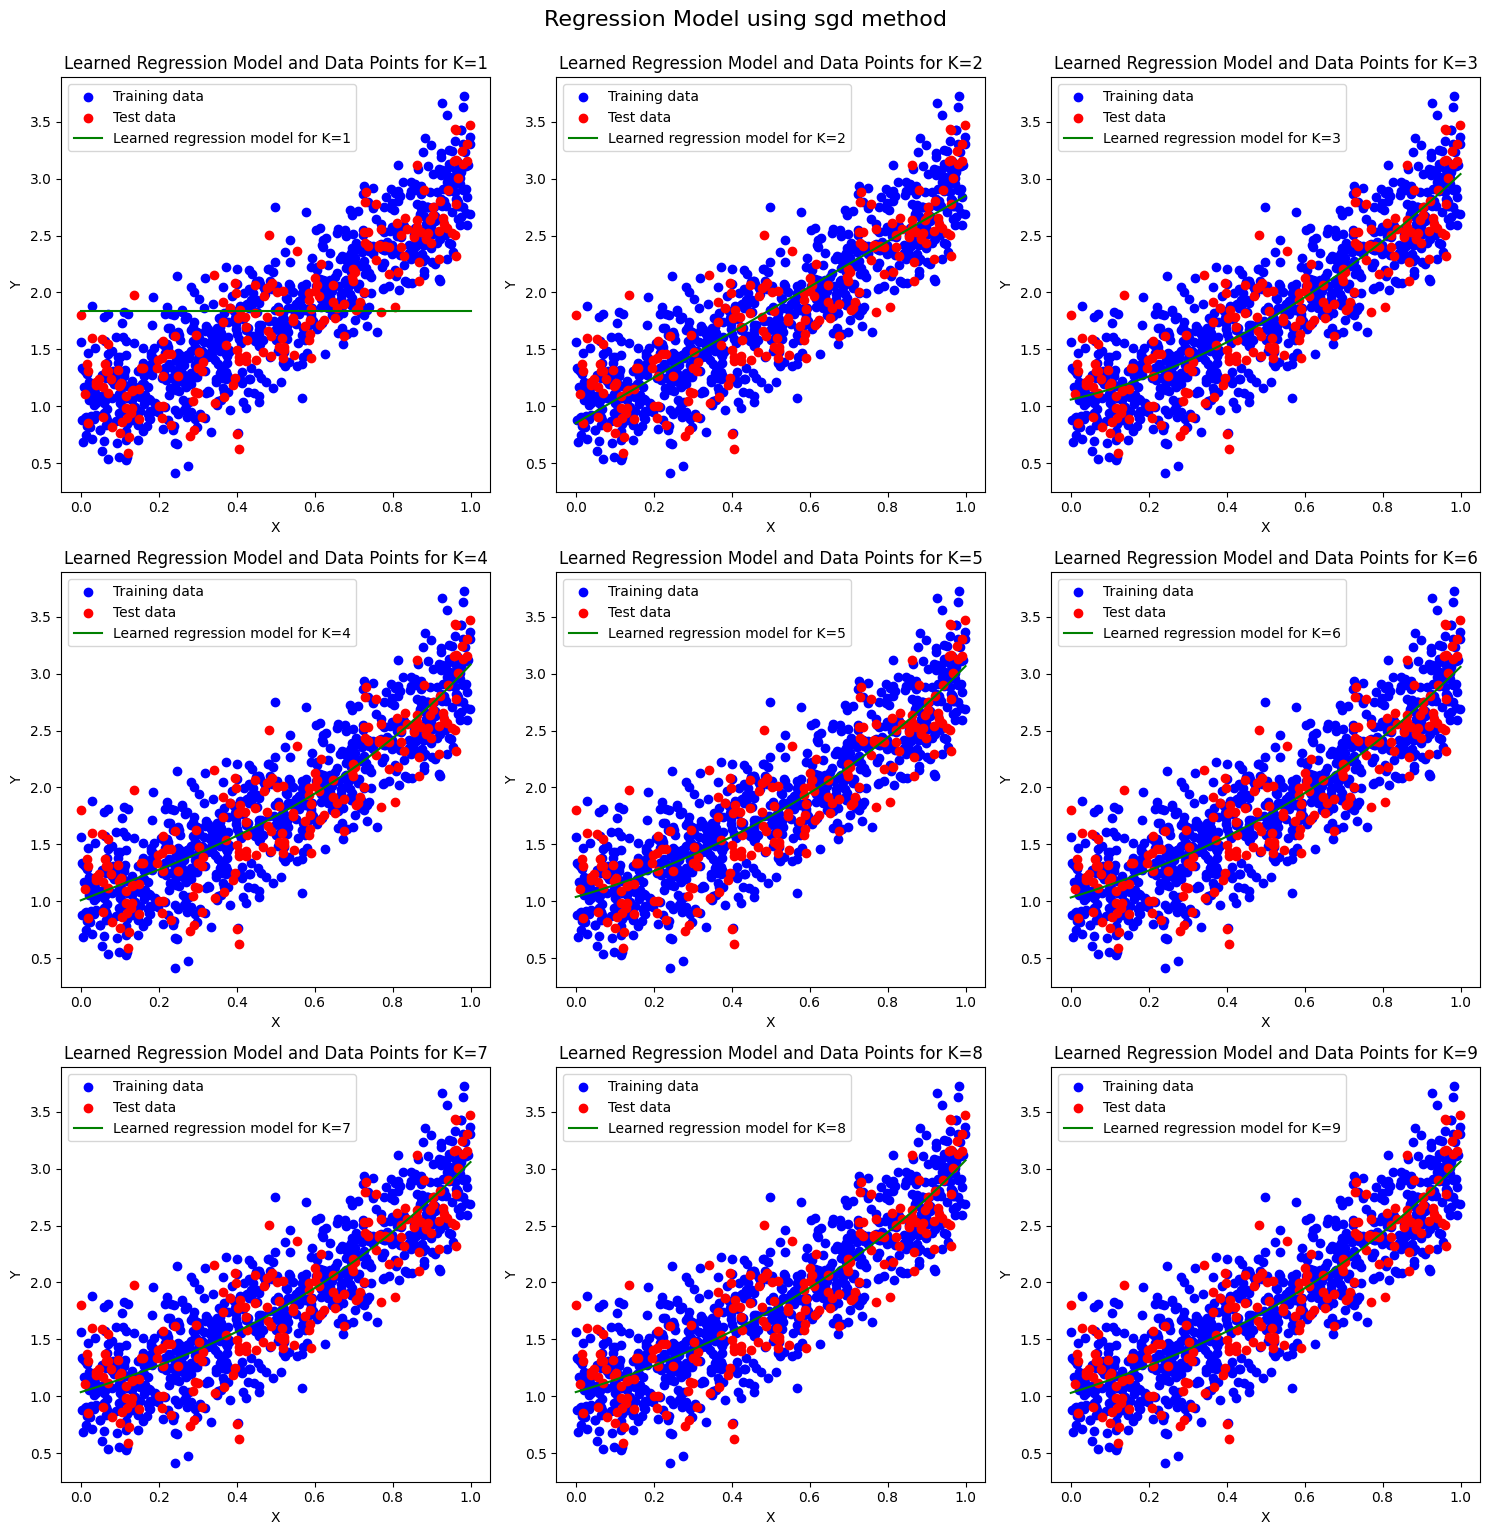

In [110]:
# Create a range of values for the continuous line plot
x_range = np.linspace(a, b, 1000)

methods = ['normal', 'gd', 'sgd']
for method in methods:
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    axs = axs.ravel()

    for K in range(1, 10):
        Phi_X_train = np.vander(X_train, N=K, increasing=True)
        # Compute the learned regression model fθMLE(x)
        if method == 'normal':
            theta = compute_mle_normal_eq(X_train, Y_train, K)
        elif method == 'gd':
            theta_list, _, _, _, _ = gradient_descent_mle(f_mle, grad_f_mle, np.random.randn(K), 10000, 1e-8, 1e-8, Phi_X_train, Y_train, do_backtracking=False, alpha_value=0.01)
            theta = theta_list[-1]
        elif method == 'sgd':
            theta_list, _, _, _ = stochastic_gradient_descent_mle(f_mle, grad_f_mle, np.random.randn(K), (Phi_X_train, Y_train), 64, 10000,0.01)
            theta = theta_list[-1]

        Phi_X_range = np.vander(x_range, N=K, increasing=True)
        f_theta = Phi_X_range @ theta

        # Plot the training and test data points
        axs[K-1].scatter(X_train, Y_train, color='blue', label='Training data')
        axs[K-1].scatter(X_test, Y_test, color='red', label='Test data')

        # Plot the learned regression model as a continuous line
        axs[K-1].plot(x_range, f_theta, color='green', label=f'Learned regression model for K={K}')

        # Add labels, title, and legend
        axs[K-1].set_xlabel('X')
        axs[K-1].set_ylabel('Y')
        axs[K-1].set_title(f'Learned Regression Model and Data Points for K={K}')
        axs[K-1].legend()

    # Show the plot
    plt.tight_layout()
    plt.suptitle(f'Regression Model using {method} method', fontsize=16, y=1.02)

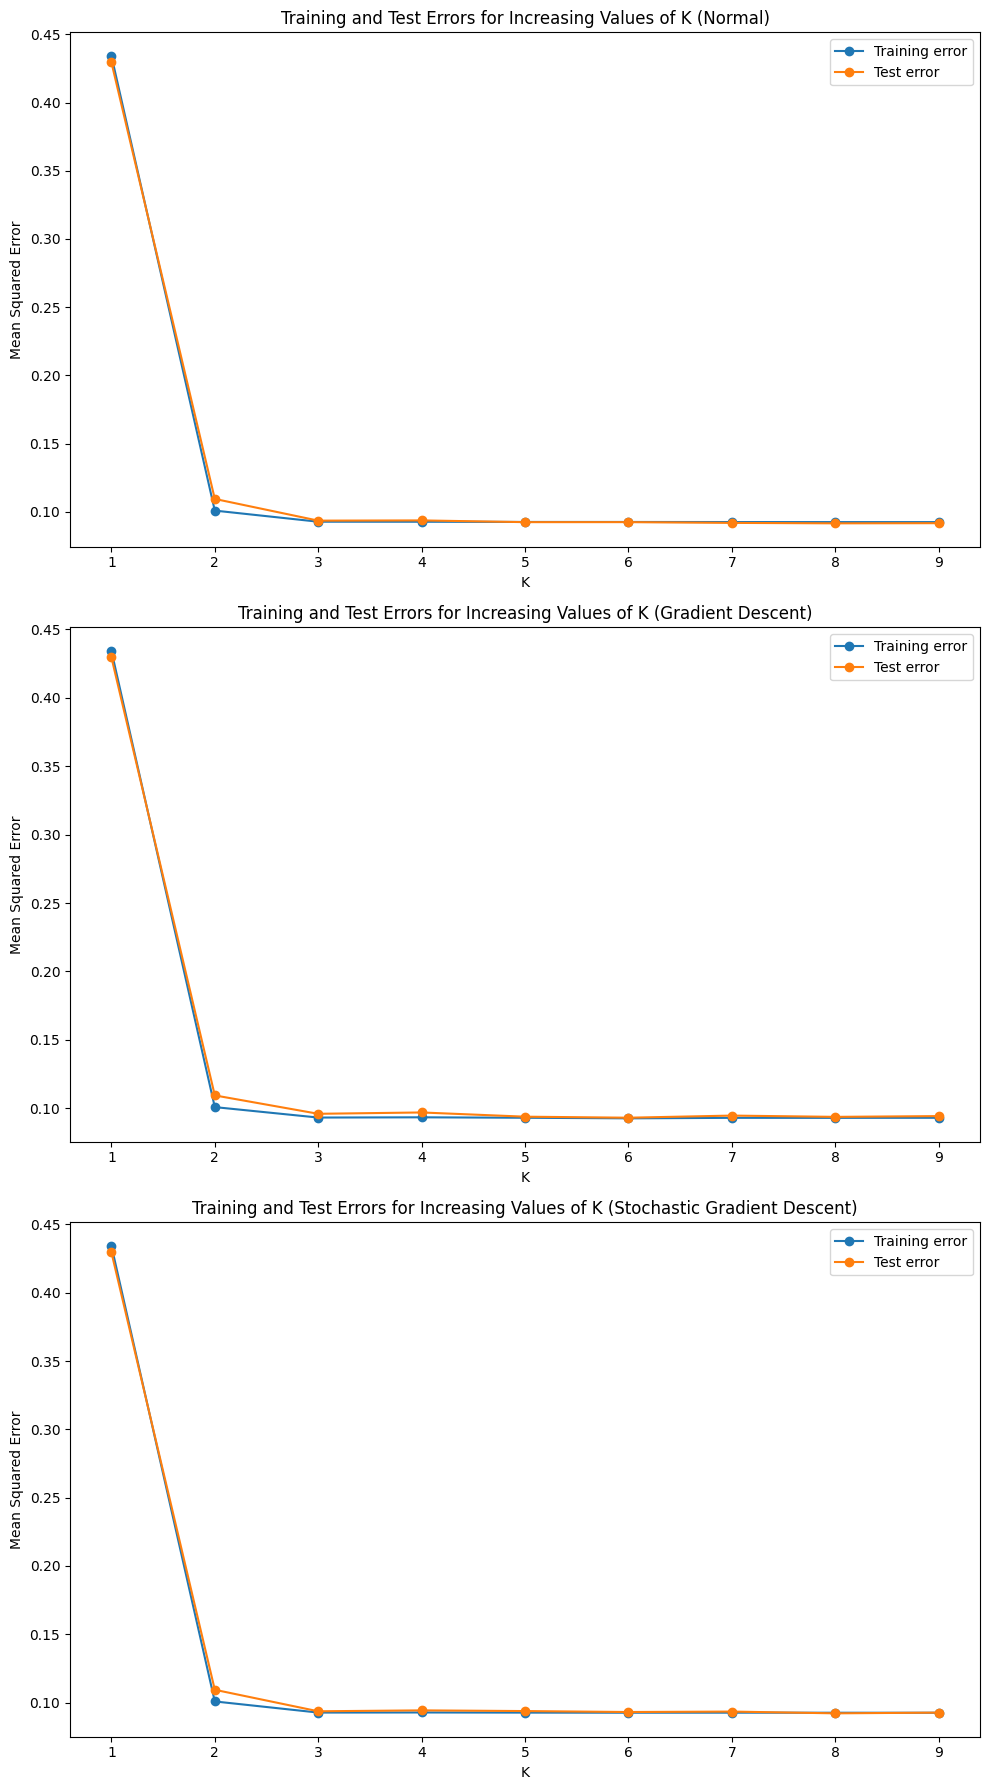

In [111]:
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Normal method
axs[0].plot(range(1, 10), mse_mle_normal_train_list, marker='o', label='Training error')
axs[0].plot(range(1, 10), mse_mle_normal_test_list, marker='o', label='Test error')
axs[0].set_xlabel('K')
axs[0].set_ylabel('Mean Squared Error')
axs[0].set_title('Training and Test Errors for Increasing Values of K (Normal)')
axs[0].legend()

# Gradient Descent method
axs[1].plot(range(1, 10), mse_mle_gd_train_list, marker='o', label='Training error')
axs[1].plot(range(1, 10), mse_mle_gd_test_list, marker='o', label='Test error')
axs[1].set_xlabel('K')
axs[1].set_ylabel('Mean Squared Error')
axs[1].set_title('Training and Test Errors for Increasing Values of K (Gradient Descent)')
axs[1].legend()

# Stochastic Gradient Descent method
axs[2].plot(range(1, 10), mse_mle_sgd_train_list, marker='o', label='Training error')
axs[2].plot(range(1, 10), mse_mle_sgd_test_list, marker='o', label='Test error')
axs[2].set_xlabel('K')
axs[2].set_ylabel('Mean Squared Error')
axs[2].set_title('Training and Test Errors for Increasing Values of K (Stochastic Gradient Descent)')
axs[2].legend()

plt.tight_layout()
plt.show()

### Visualization MAP

In [112]:
mse_map_normal_train_list = {}
mse_map_normal_test_list = {}
mse_map_gd_train_list = {}
mse_map_gd_test_list = {}
mse_map_sgd_train_list = {}
mse_map_sgd_test_list = {}


for lambda_ in [0.1, 10]:
    mse_map_normal_train_list[lambda_] = []
    mse_map_normal_test_list[lambda_] = []
    mse_map_gd_train_list[lambda_] = []
    mse_map_gd_test_list[lambda_] = []
    mse_map_sgd_train_list[lambda_] = []
    mse_map_sgd_test_list[lambda_] = []
    for K in range(1, 10):
        Phi_X_train = np.vander(X_train, N=K, increasing=True)
        Phi_X_test = np.vander(X_test, N=K, increasing=True)
        # Normal Equation
        theta_map_normal = compute_map_normal_eq(X_train, Y_train, K, 0.1)
        # Gradient Descent
        theta_list_map, _, _, _, _ = gradient_descent_map(f_map, grad_f_map, np.random.randn(K), 10000, 1e-8, 1e-8, Phi_X_train, Y_train, do_backtracking=False, alpha_value=0.01, lambda_=0.1)
        theta_map_gd = theta_list_map[-1]
        # Stochastic Gradient Descent
        theta_list_sgd, _, _, _ = stochastic_gradient_descent_map(f_map, grad_f_map, np.random.randn(K), (Phi_X_train, Y_train), 64, 10000,0.01, lambda_=0.1)
        theta_map_sgd = theta_list_sgd[-1]
        
        mse_map_normal_train = MSE(theta_map_normal, Phi_X_train, Y_train, K)
        mse_map_normal_test = MSE(theta_map_normal, Phi_X_test, Y_test, K)
        mse_map_gd_train = MSE(theta_map_gd, Phi_X_train, Y_train, K)
        mse_map_gd_test = MSE(theta_map_gd, Phi_X_test, Y_test, K)
        mse_map_sgd_train = MSE(theta_map_sgd, Phi_X_train, Y_train, K)
        mse_map_sgd_test = MSE(theta_map_sgd, Phi_X_test, Y_test, K)
        
        mse_map_normal_train_list[lambda_].append(mse_map_normal_train)
        mse_map_normal_test_list[lambda_].append(mse_map_normal_test)
        mse_map_gd_train_list[lambda_].append(mse_map_gd_train)
        mse_map_gd_test_list[lambda_].append(mse_map_gd_test)
        mse_map_sgd_train_list[lambda_].append(mse_map_sgd_train)
        mse_map_sgd_test_list[lambda_].append(mse_map_sgd_test)
        

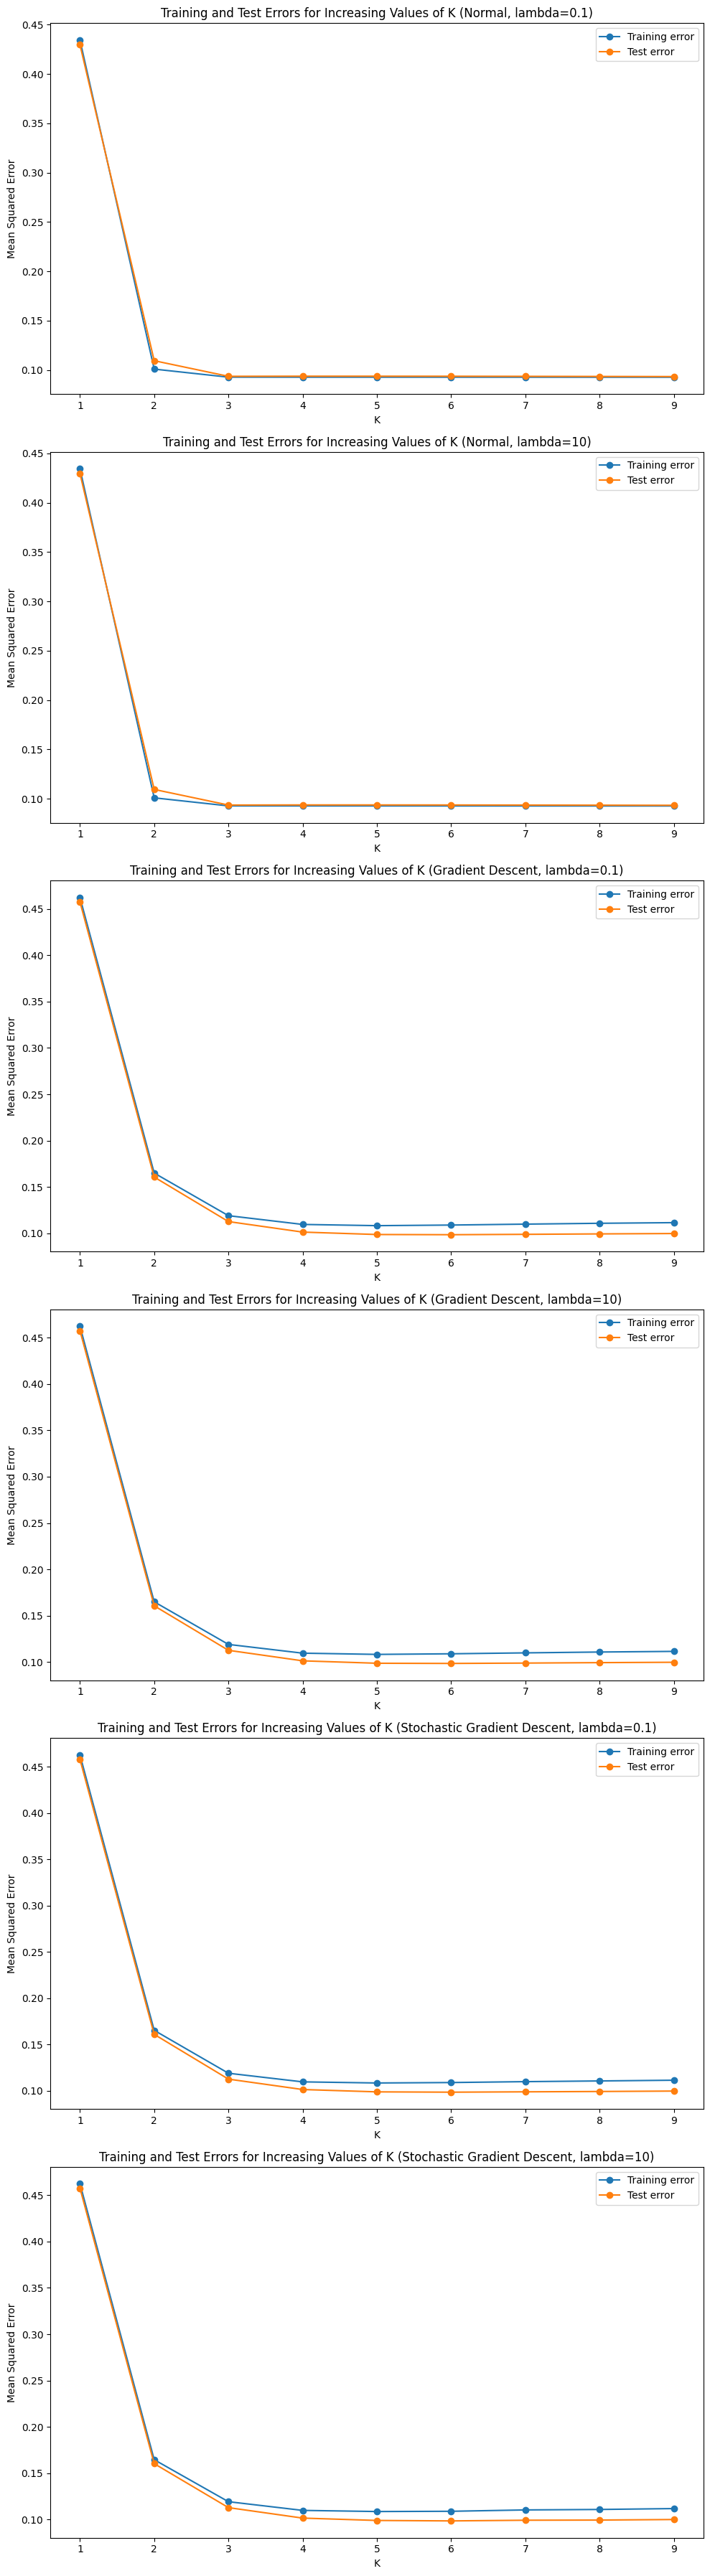

In [113]:
fig, axs = plt.subplots(6, 1, figsize=(10, 36))

# Normal method
for i, lambda_ in enumerate([0.1, 10]):
    axs[i].plot(range(1, 10), mse_map_normal_train_list[lambda_], marker='o', label='Training error')
    axs[i].plot(range(1, 10), mse_map_normal_test_list[lambda_], marker='o', label='Test error')
    axs[i].set_xlabel('K')
    axs[i].set_ylabel('Mean Squared Error')
    axs[i].set_title(f'Training and Test Errors for Increasing Values of K (Normal, lambda={lambda_})')
    axs[i].legend()

# Gradient Descent method
for i, lambda_ in enumerate([0.1, 10], start=2):
    axs[i].plot(range(1, 10), mse_map_gd_train_list[lambda_], marker='o', label='Training error')
    axs[i].plot(range(1, 10), mse_map_gd_test_list[lambda_], marker='o', label='Test error')
    axs[i].set_xlabel('K')
    axs[i].set_ylabel('Mean Squared Error')
    axs[i].set_title(f'Training and Test Errors for Increasing Values of K (Gradient Descent, lambda={lambda_})')
    axs[i].legend()

# Stochastic Gradient Descent method
for i, lambda_ in enumerate([0.1, 10], start=4):
    axs[i].plot(range(1, 10), mse_map_sgd_train_list[lambda_], marker='o', label='Training error')
    axs[i].plot(range(1, 10), mse_map_sgd_test_list[lambda_], marker='o', label='Test error')
    axs[i].set_xlabel('K')
    axs[i].set_ylabel('Mean Squared Error')
    axs[i].set_title(f'Training and Test Errors for Increasing Values of K (Stochastic Gradient Descent, lambda={lambda_})')
    axs[i].legend()

plt.tight_layout()
plt.show()

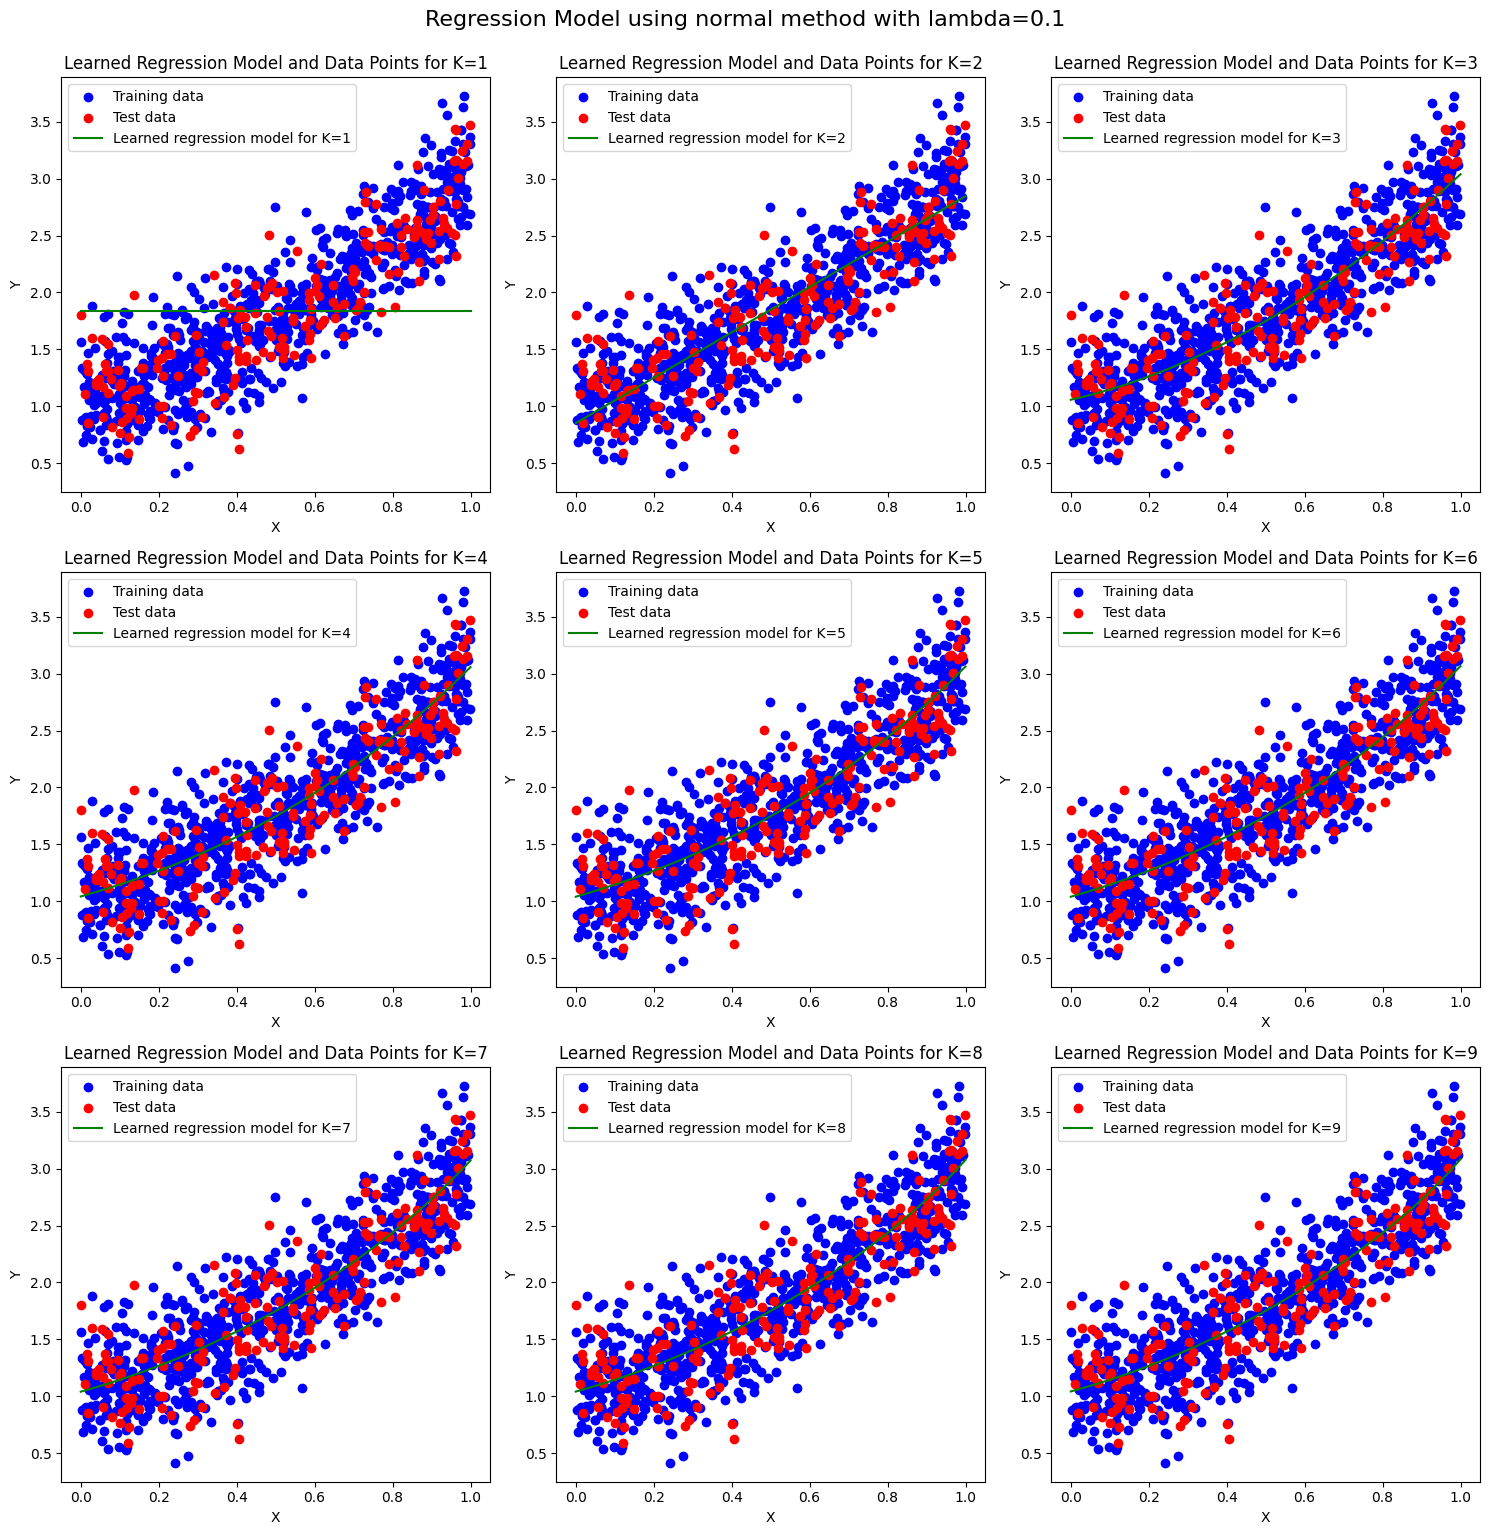

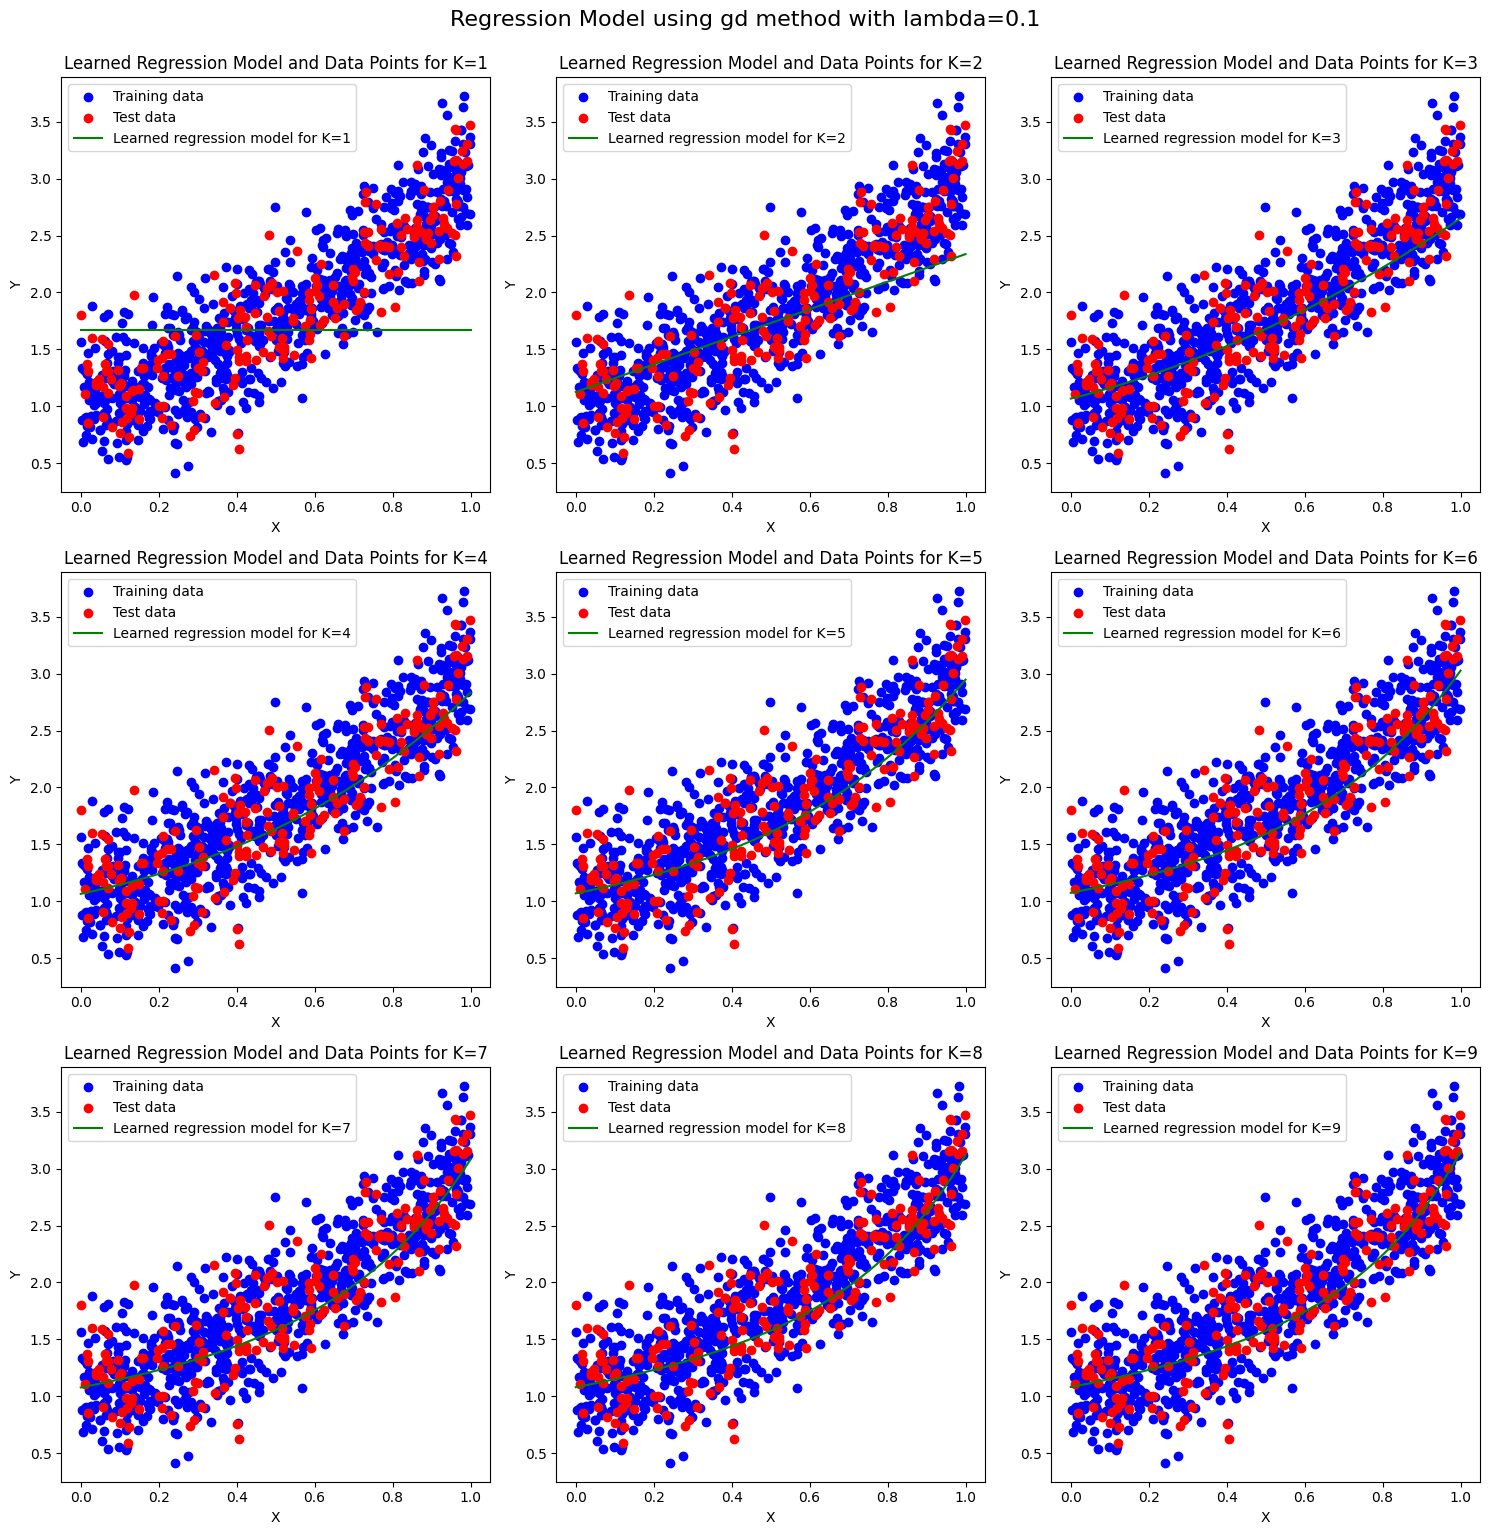

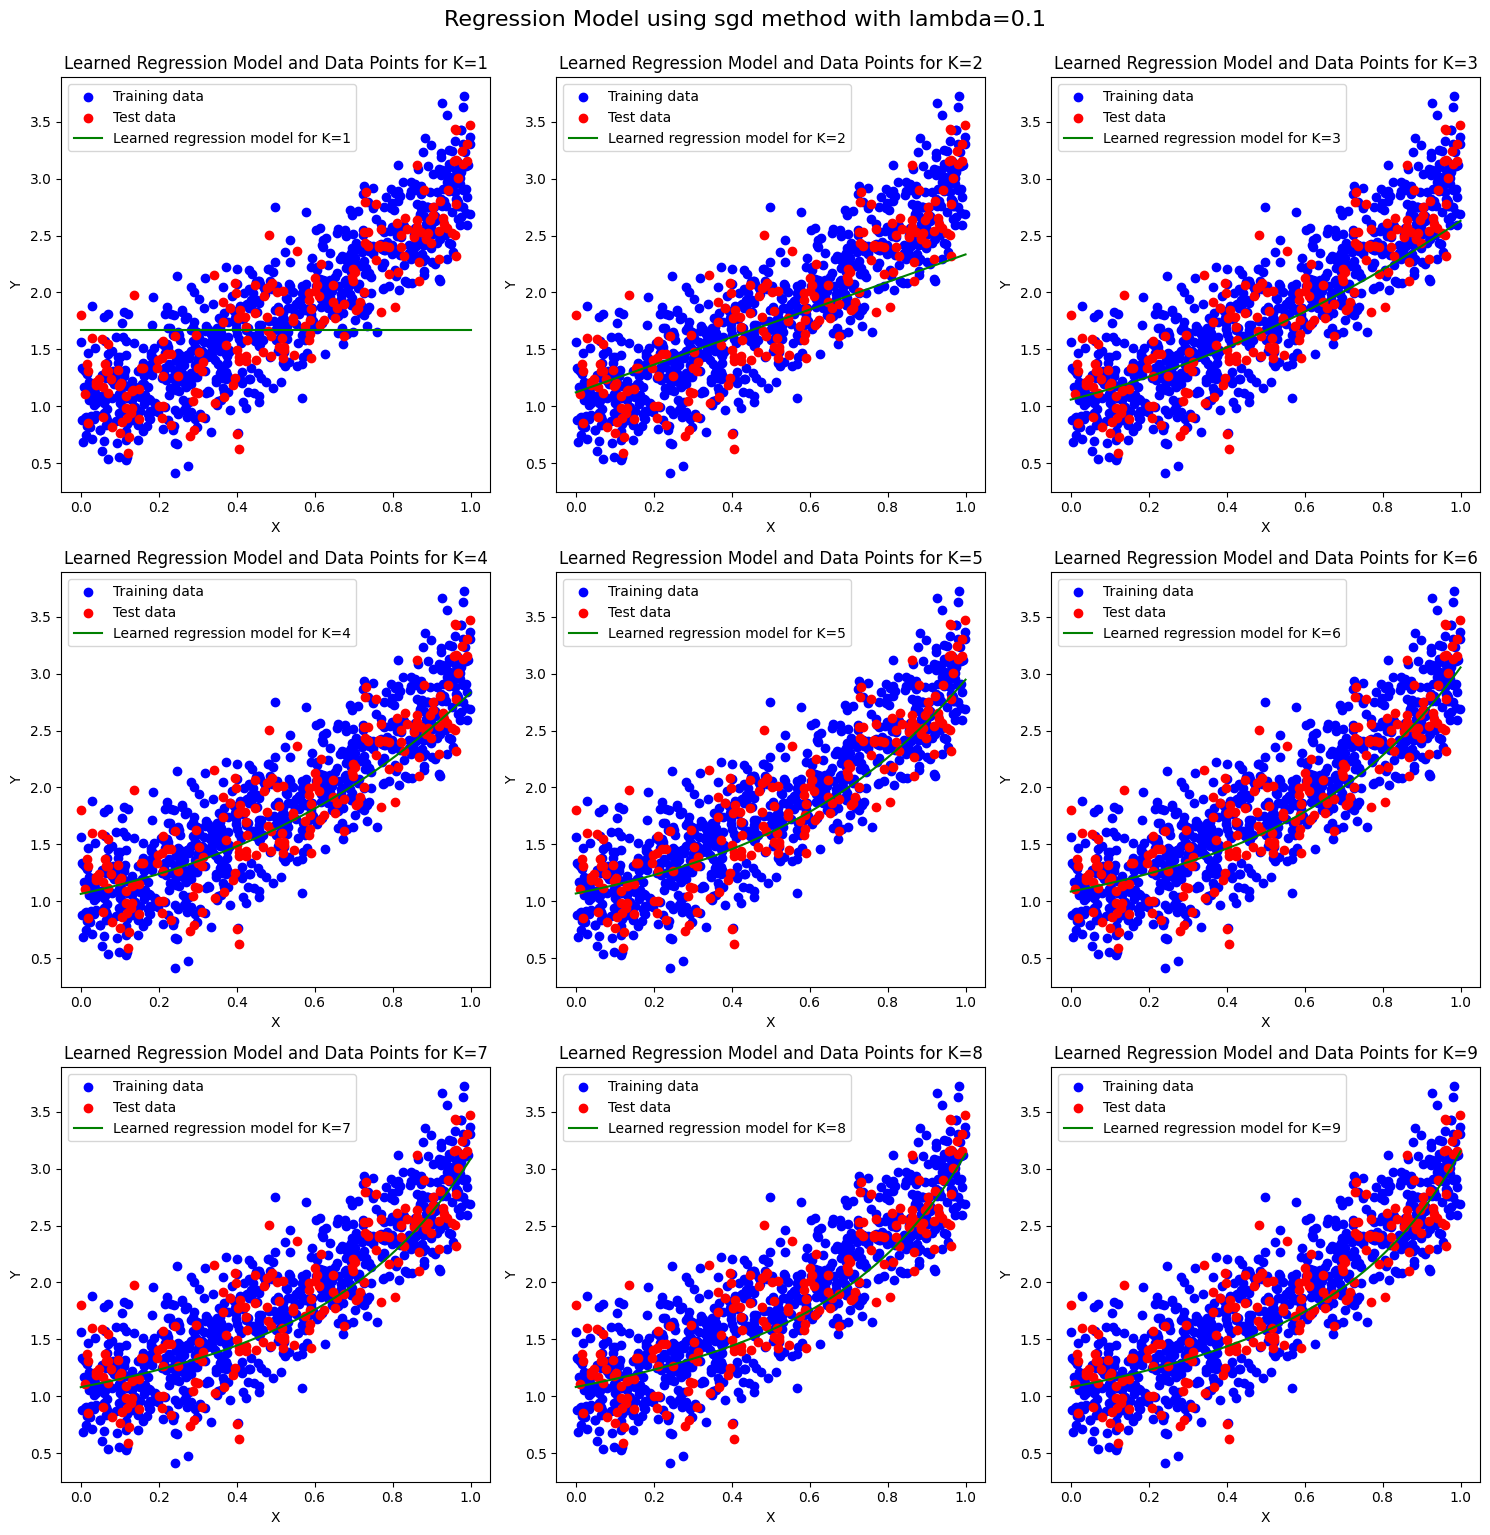

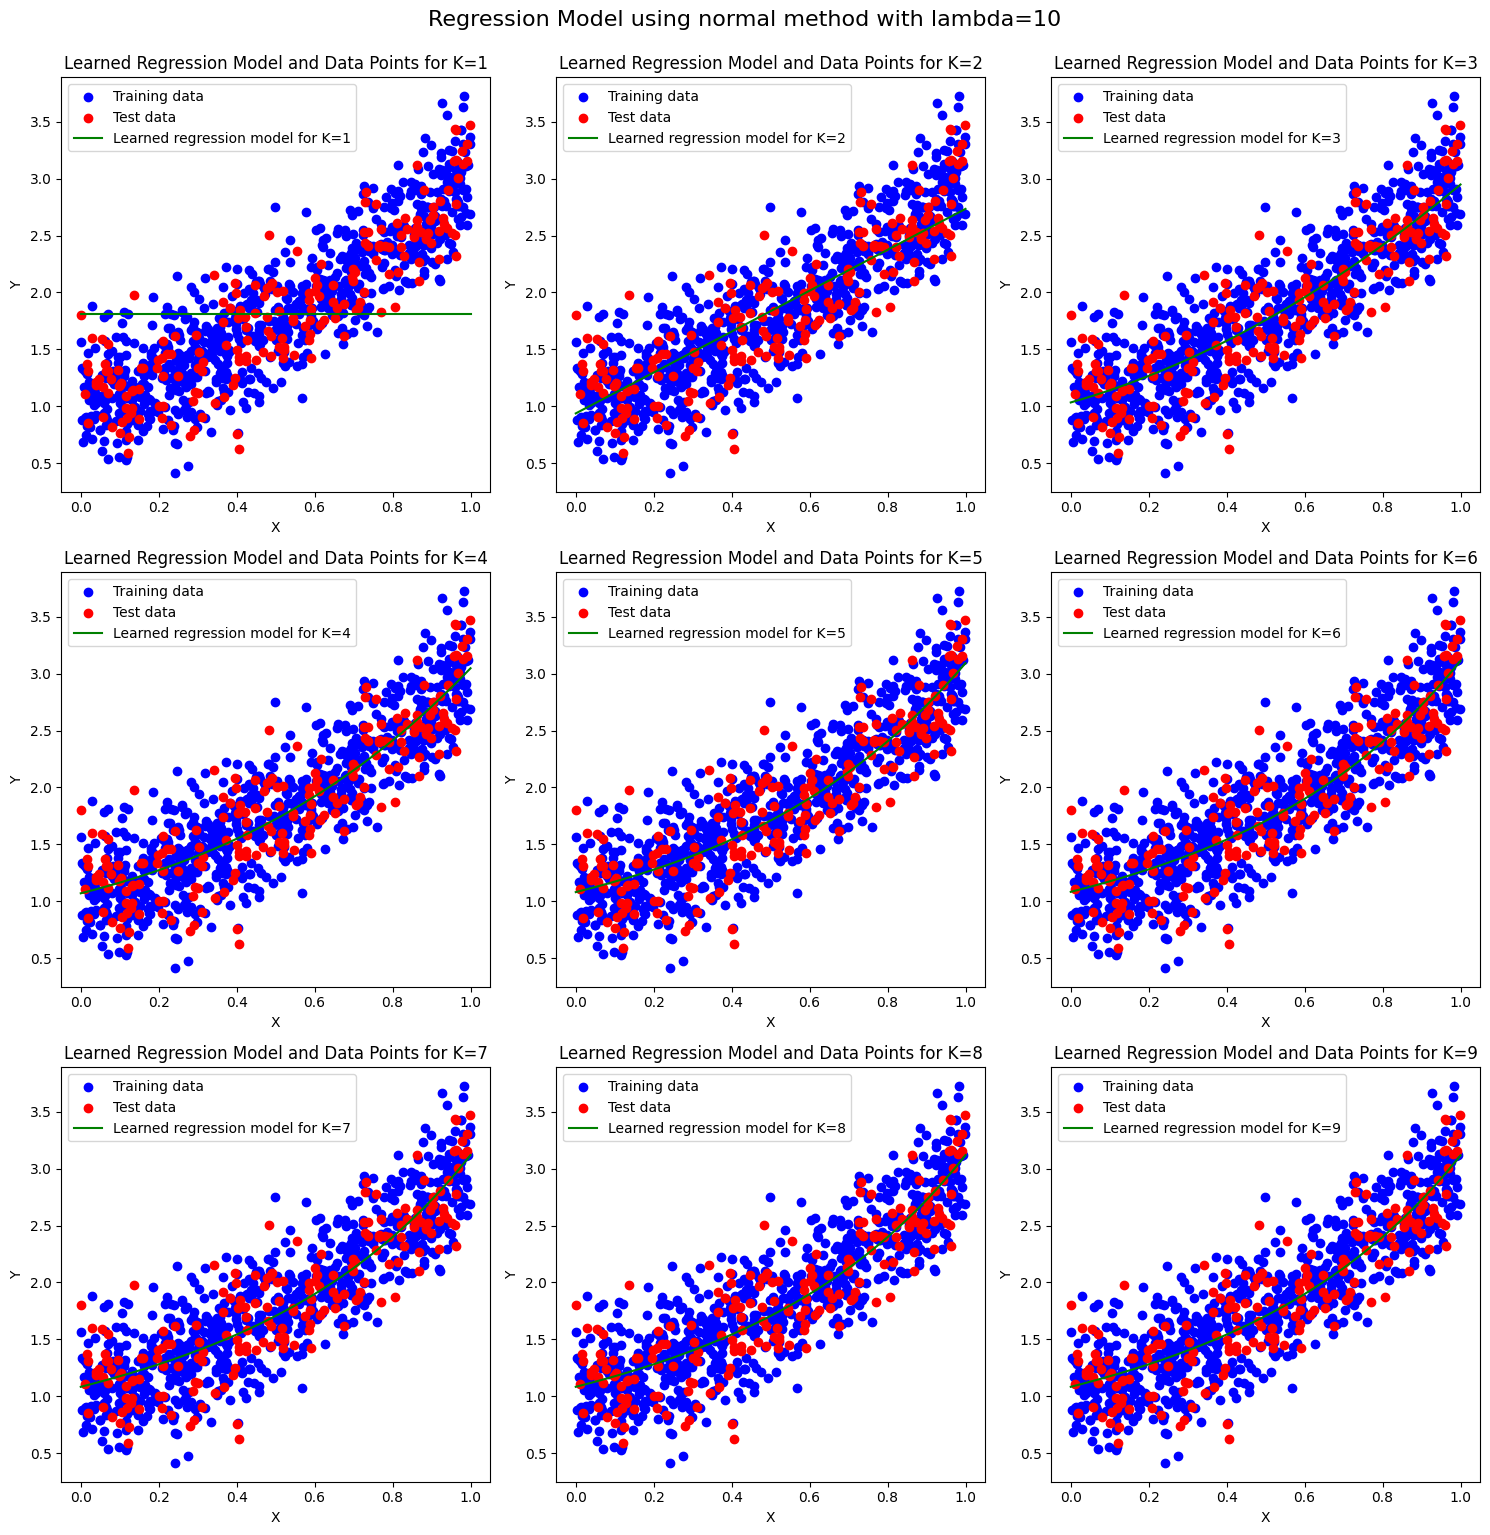

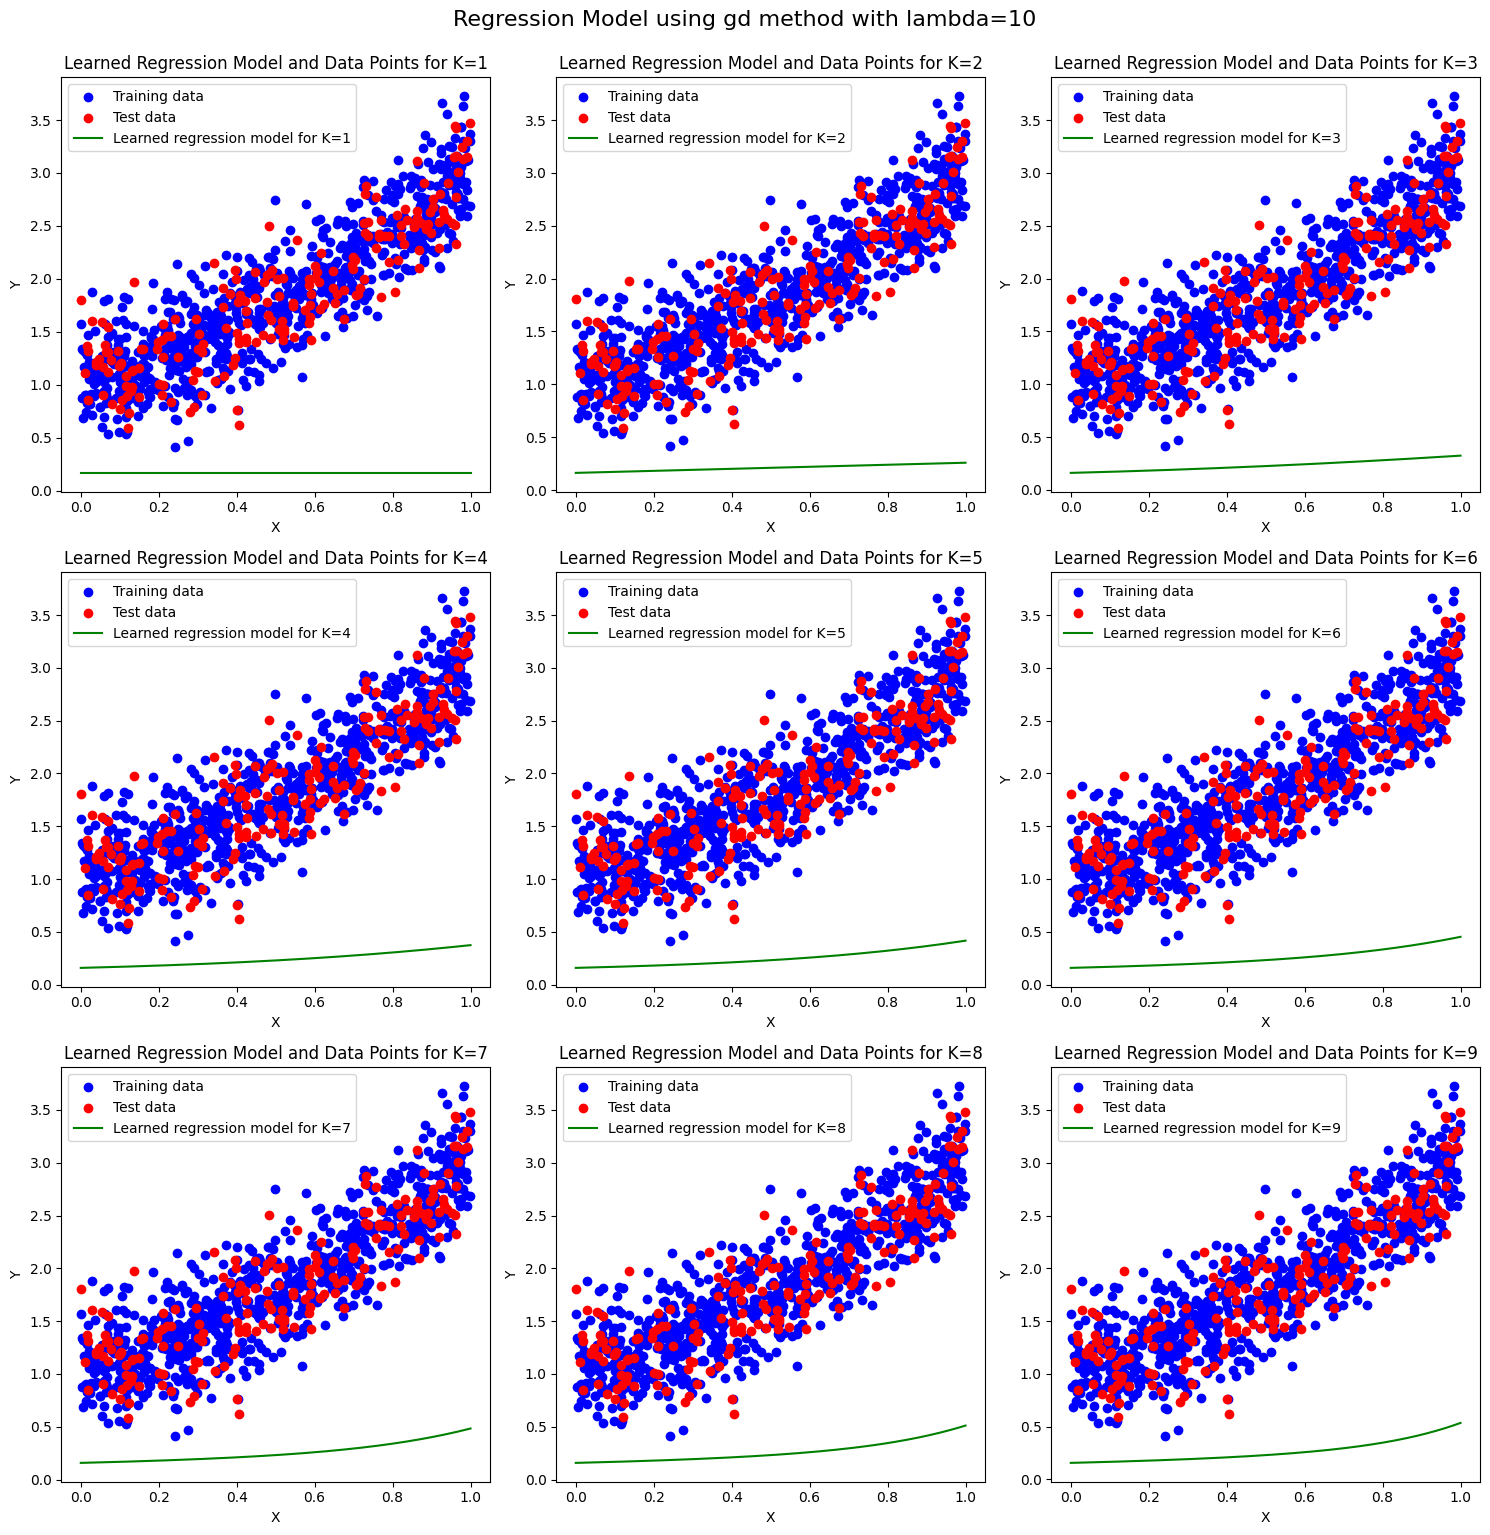

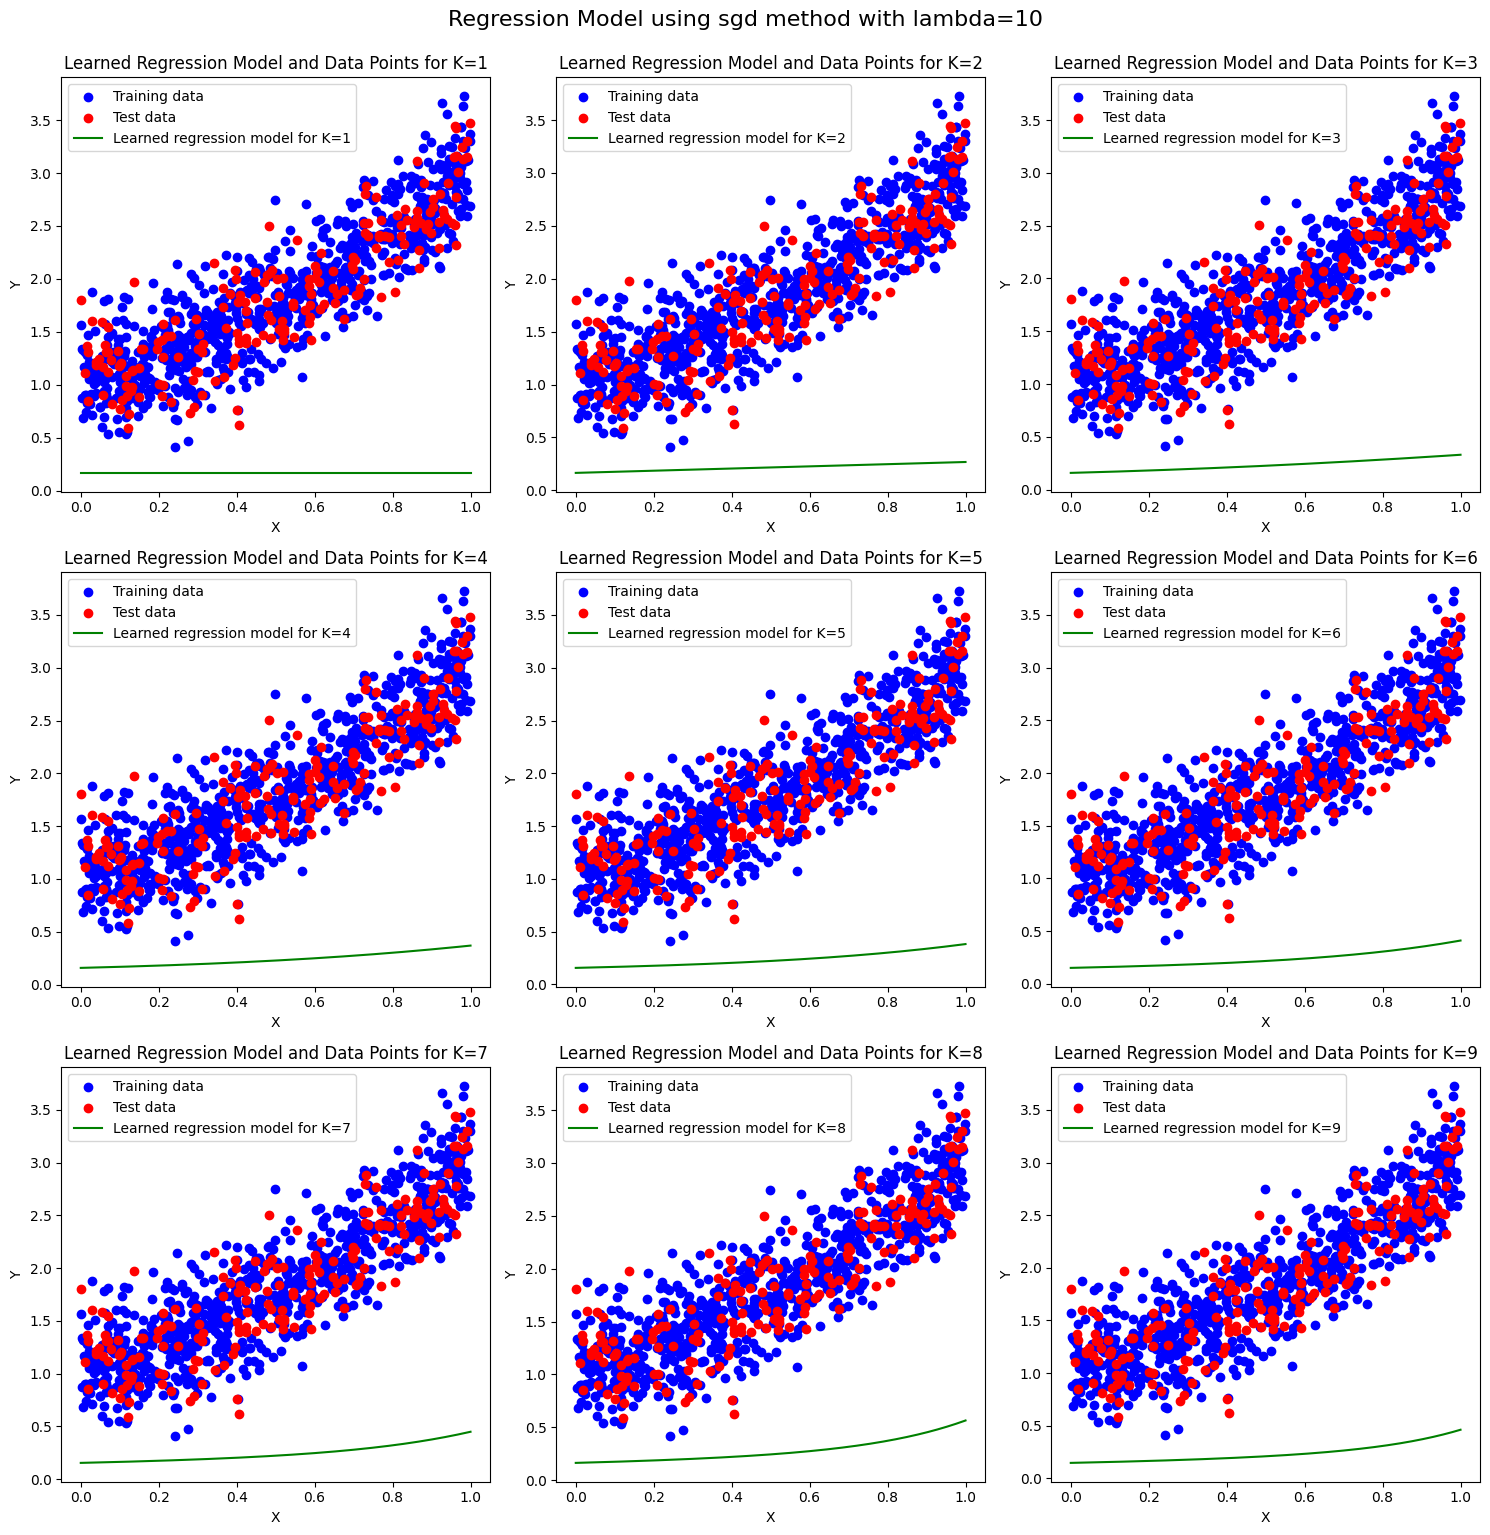

In [114]:
# Create a range of x values for the continuous line plot
x_range = np.linspace(a, b, 1000)

methods = ['normal', 'gd', 'sgd']
lambdas = [0.1, 10]

for lambda_ in lambdas:
    for method in methods:
        fig, axs = plt.subplots(3, 3, figsize=(15, 15))
        axs = axs.ravel()

        for K in range(1, 10):
            Phi_X_train = np.vander(X_train, N=K, increasing=True)
            # Compute the learned regression model fθMLE(x)
            if method == 'normal':
                theta = compute_map_normal_eq(X_train, Y_train, K, lambda_)
            elif method == 'gd':
                theta_list, _, _, _, _ = gradient_descent_map(f_map, grad_f_map, np.random.randn(K), 10000, 1e-8, 1e-8, Phi_X_train, Y_train, do_backtracking=False, alpha_value=0.01, lambda_=lambda_)
                theta = theta_list[-1]
            elif method == 'sgd':
                theta_list, _, _, _ = stochastic_gradient_descent_map(f_map, grad_f_map, np.random.randn(K), (Phi_X_train, Y_train), 8, 10000,0.01, lambda_=lambda_)
                theta = theta_list[-1]

            Phi_X_range = np.vander(x_range, N=K, increasing=True)
            f_theta = Phi_X_range @ theta

            # Plot the training and test data points
            axs[K-1].scatter(X_train, Y_train, color='blue', label='Training data')
            axs[K-1].scatter(X_test, Y_test, color='red', label='Test data')

            # Plot the learned regression model as a continuous line
            axs[K-1].plot(x_range, f_theta, color='green', label=f'Learned regression model for K={K}')

            # Add labels, title, and legend
            axs[K-1].set_xlabel('X')
            axs[K-1].set_ylabel('Y')
            axs[K-1].set_title(f'Learned Regression Model and Data Points for K={K}')
            axs[K-1].legend()

        # Show the plot
        plt.tight_layout()
        plt.suptitle(f'Regression Model using {method} method with lambda={lambda_}', fontsize=16, y=1.02)
        plt.show()

In [115]:
# Set K to a value greater than the correct degree of the polynomial
K = 20  # Change this to your desired value

Phi_X_test = np.vander(X_test, N=K, increasing=True)
# Compute the MLE solution
theta_mle = compute_mle_normal_eq(X_train, Y_train, K)


# Compute the test error for the MLE solution
mse_mle_test = MSE(theta_mle, Phi_X_test, Y_test, K)

# Print the test error for the MLE solution
print(f"Test error for MLE solution: {mse_mle_test}")

# Define a list of different lambda values
lambdas = [0.1, 1, 10, 100]

# Compute the MAP solution and test error for each lambda value
for lambda_ in lambdas:
    theta_map = compute_map_normal_eq(X_train, Y_train, K, lambda_)
    mse_map_test = MSE(theta_map, Phi_X_test, Y_test, K)
    print(f"Test error for MAP solution with lambda={lambda_}: {mse_map_test}")

Test error for MLE solution: 102.83006141395086
Test error for MAP solution with lambda=0.1: 0.09276581166652627
Test error for MAP solution with lambda=1: 0.09285122227733027
Test error for MAP solution with lambda=10: 0.09212268018160438
Test error for MAP solution with lambda=100: 0.10635268724132396


In [119]:
def Err(theta, theta_true):
    theta_true_padded = np.pad(theta_true, (0, len(theta) - len(theta_true)))
    return np.linalg.norm(theta - theta_true_padded) / np.linalg.norm(theta_true_padded)

Err_mle = {}
Err_map = {}

K_values = range(4, 21)  
lambdas = [0.1, 1, 10, 100]

for K in K_values:
    theta_mle = compute_mle_normal_eq(X_train, Y_train, K)
    Err_mle[K] = Err(theta_mle, theta_true)
    for lambda_ in lambdas:
        theta_map = compute_map_normal_eq(X_train, Y_train, K, lambda_)
        Err_map[(K, lambda_)] = Err(theta_map, theta_true)

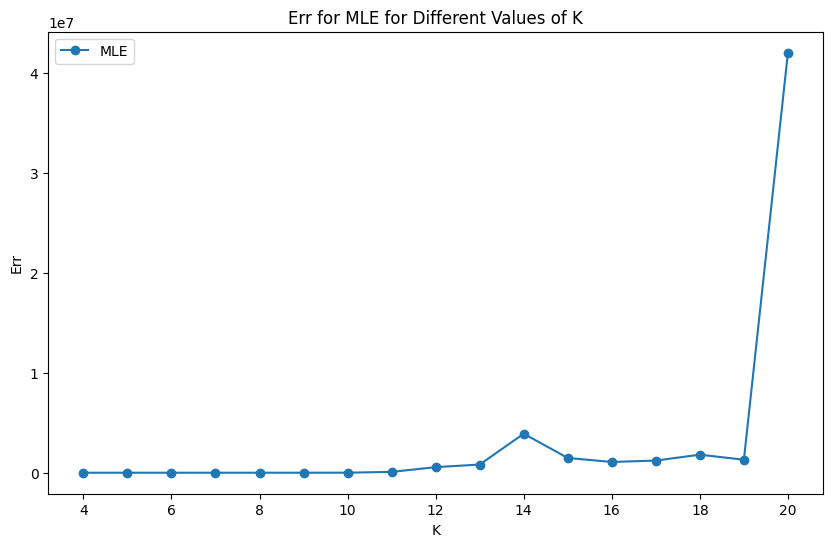

In [120]:
# Extract the Err values for MLE and MAP
err_mle_values = list(Err_mle.values())
err_map_values = {lambda_: [Err_map[(K, lambda_)] for K in K_values] for lambda_ in lambdas}

# Create the plot for MLE
plt.figure(figsize=(10, 6))
plt.plot(K_values, err_mle_values, marker='o', label='MLE')

# Add labels, title, and legend
plt.xlabel('K')
plt.ylabel('Err')
plt.title('Err for MLE for Different Values of K')
plt.legend()

# Show the plot
plt.show()

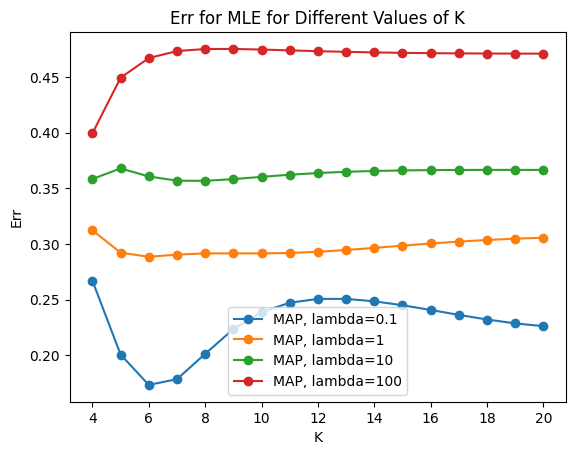

In [118]:
# Create the plots for MAP
for lambda_, err_values in err_map_values.items():
    plt.plot(K_values, err_values, marker='o', label=f'MAP, lambda={lambda_}')

# Add labels, title, and legend
plt.xlabel('K')
plt.ylabel('Err')
plt.title('Err for MAP for Different Values of K and lambda')
plt.legend()

# Show the plot
plt.show()